In [2]:
import pandas as pd

In [138]:
pass_data = pd.read_csv("/Users/annadaugaard/Desktop/VFF/VFF_analytics_src/data/03_model_data/test_for_streamit.csv")
gps_data=  pd.read_csv("/Users/annadaugaard/Desktop/VFF/preprocessed_data_for_decision_making.csv", index_col=0)

In [118]:
gps_data_home = gps_data[gps_data["Team"]== "home"]

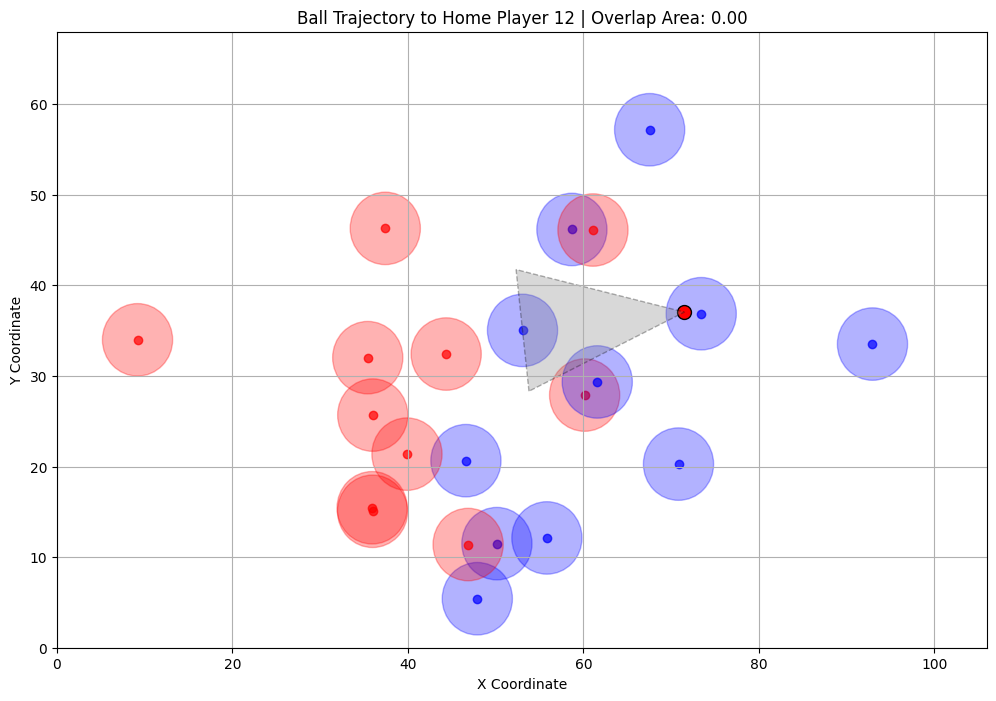

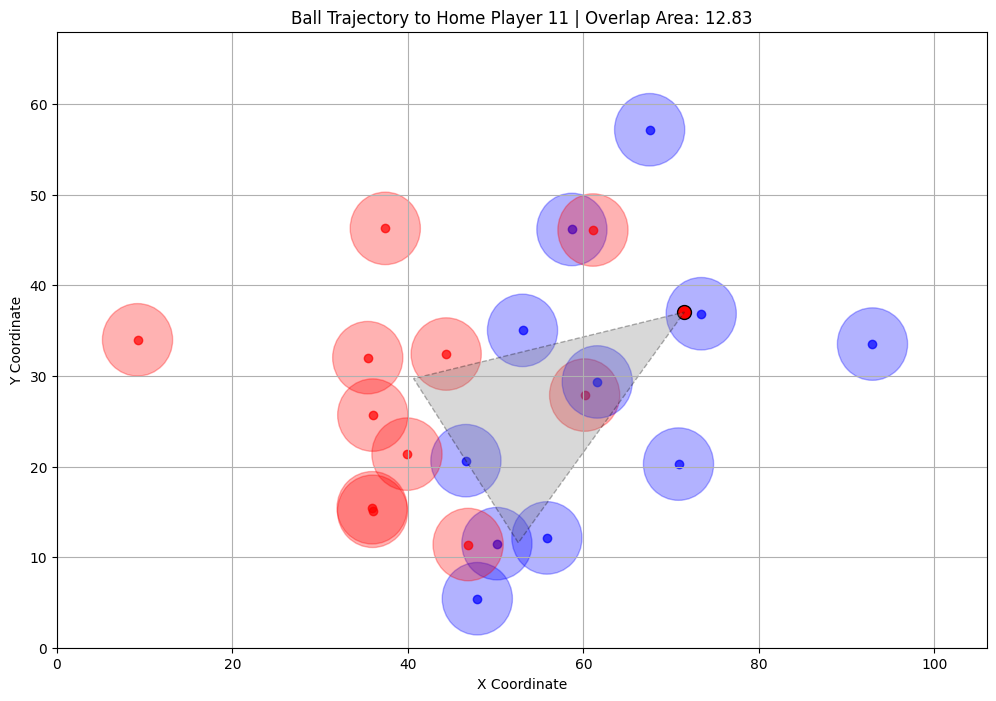

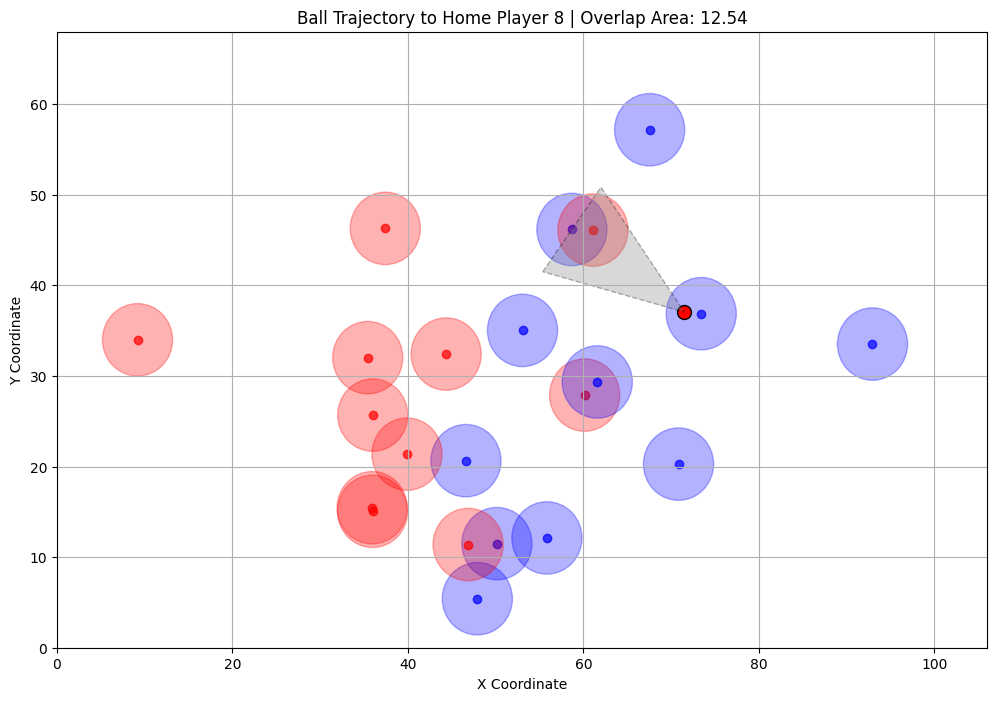

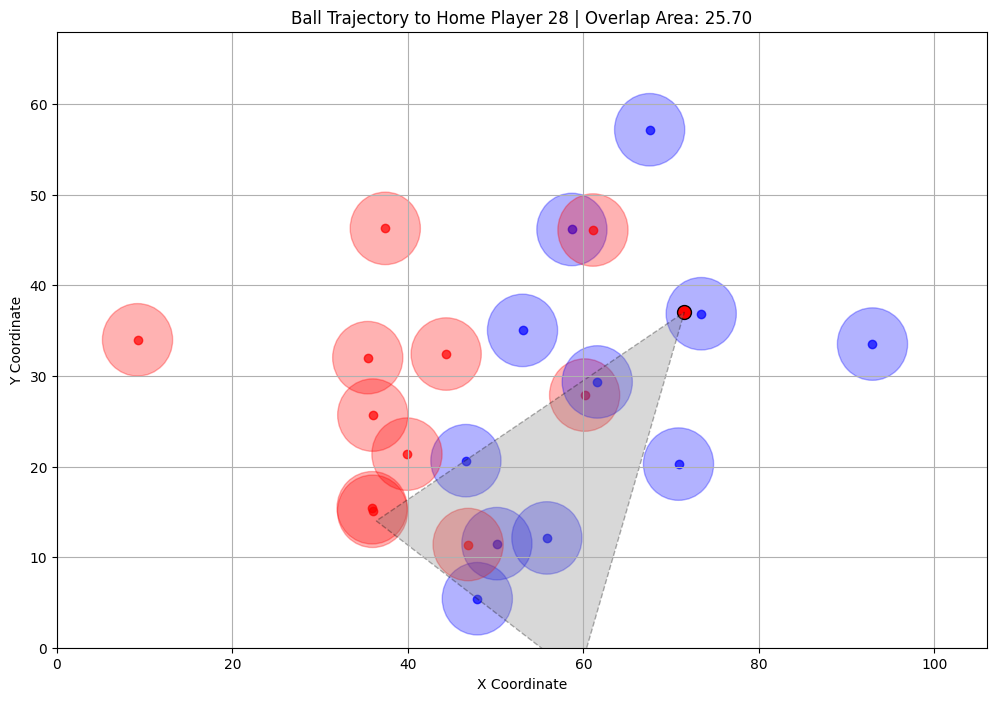

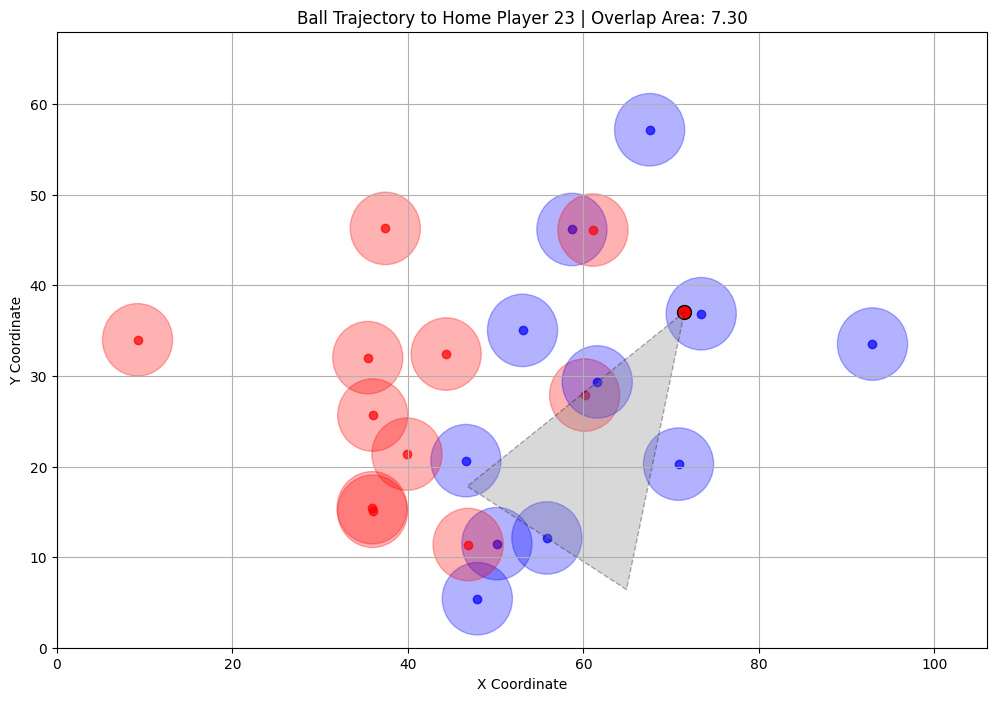

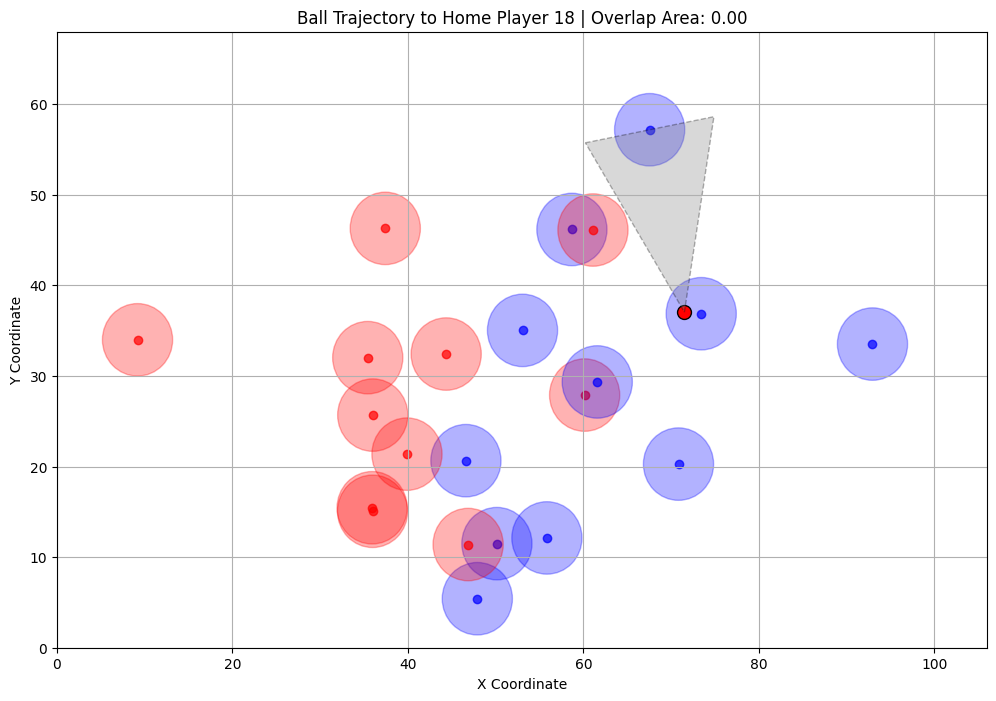

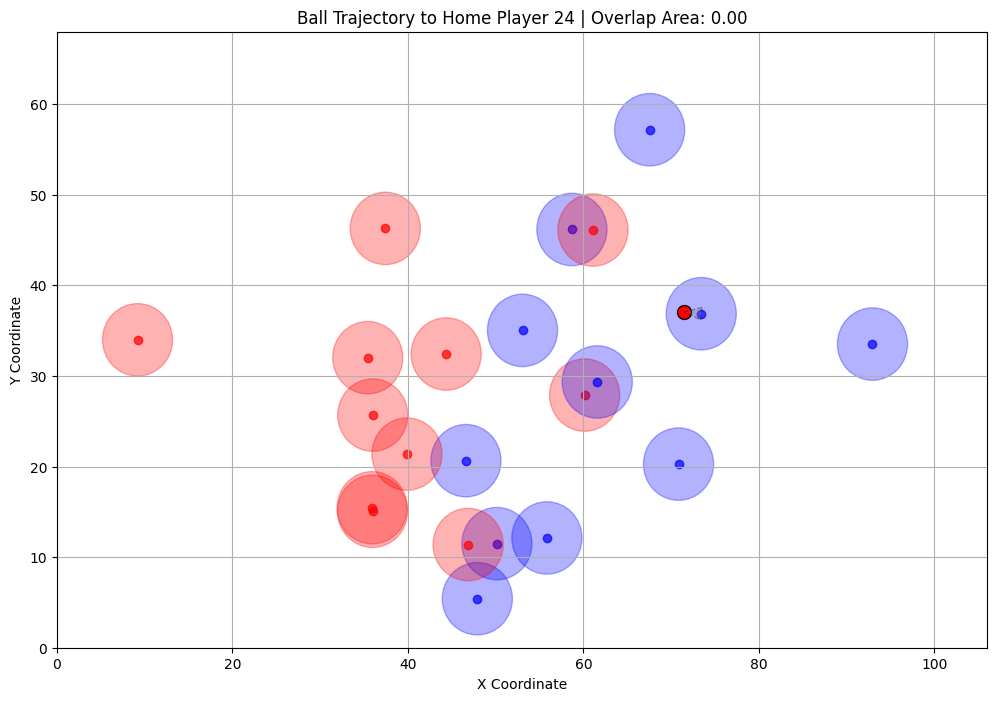

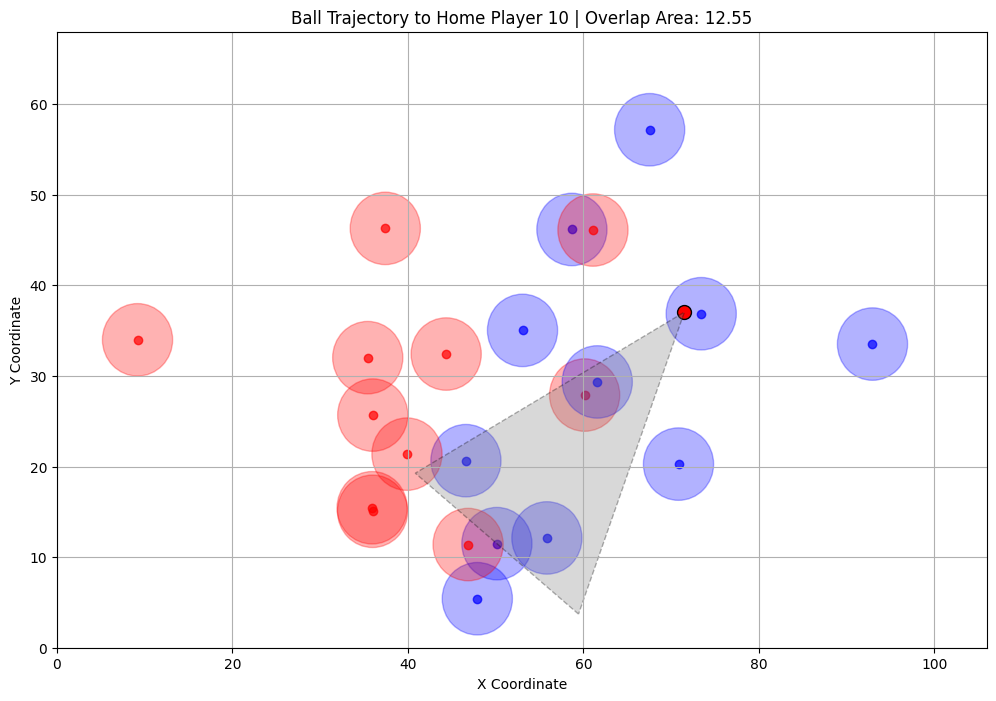

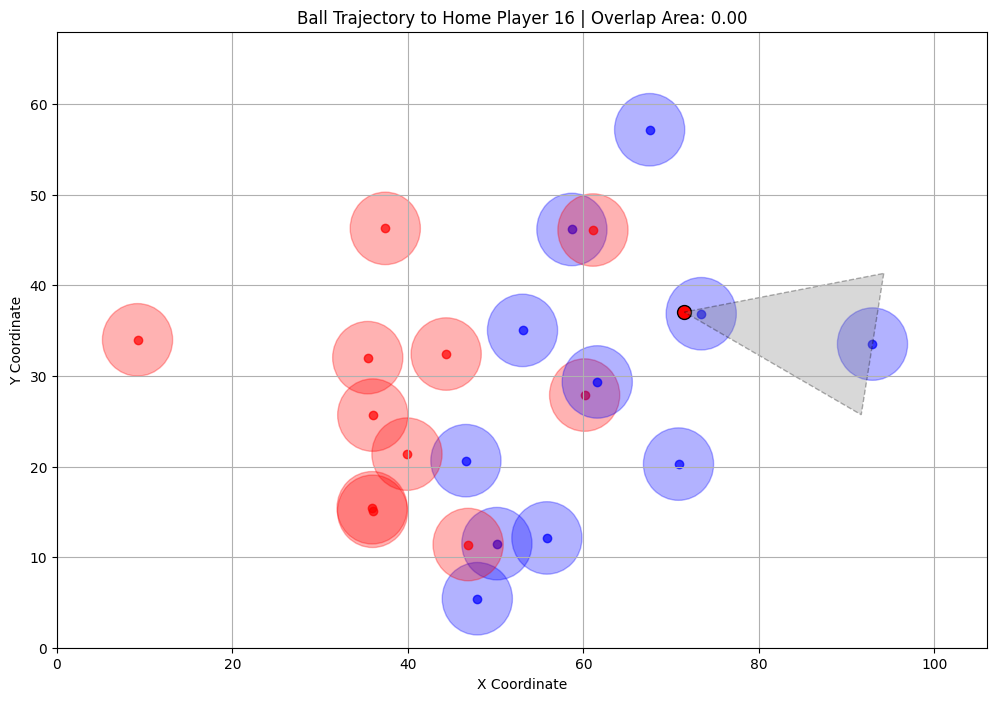

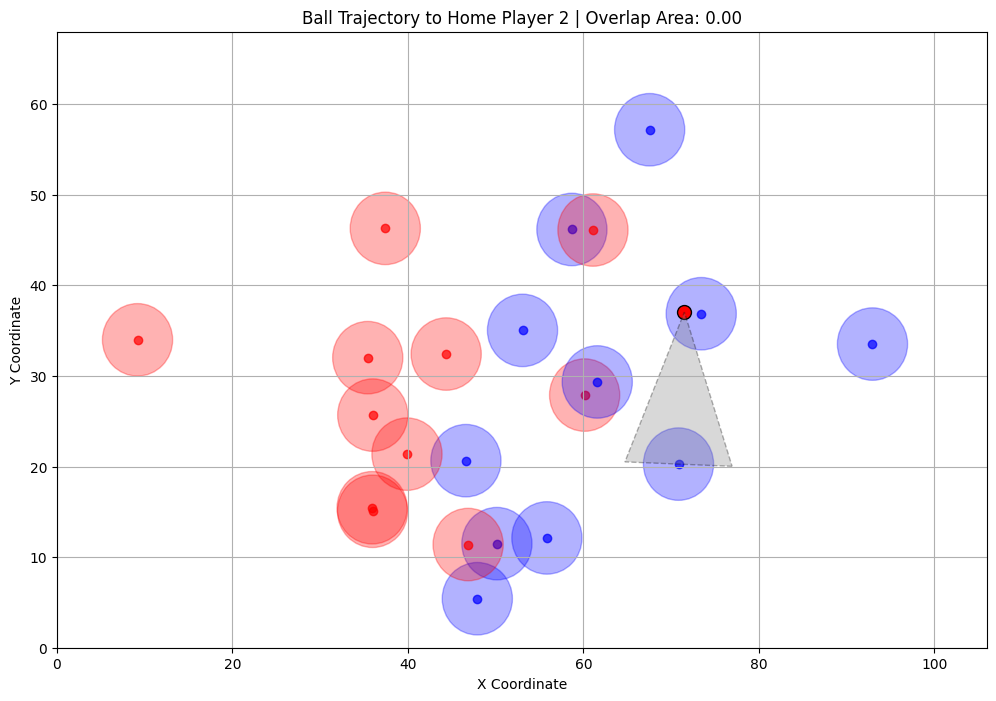

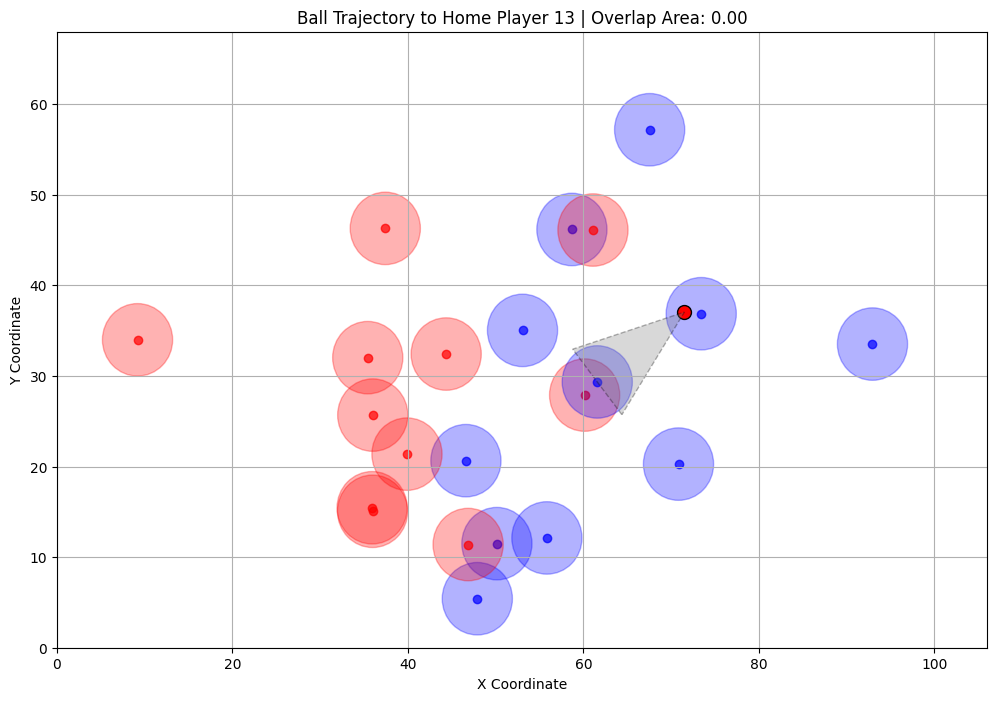

In [ ]:
def plot_trajectories_with_overlap(df, x_ball, y_ball, angle_degrees):
    import matplotlib.patches as patches
    import numpy as np
    import matplotlib.pyplot as plt
    from shapely.geometry import Polygon, Point

    # Filter home and away players
    home_players = df[df["Team"] == "home"]
    away_players = df[df["Team"] == "away"]

    # Ensure there are home players
    if home_players.empty:
        print("No home players found. Cannot plot trajectories.")
        return

    # Define team colors 
    team_colors = {"home": "blue", "away": "red"}

    # Loop over each home player and generate a separate plot
    for i, (_, target_player) in enumerate(home_players.iterrows()):
        # Compute trajectory angle
        dx = target_player["x"] - x_ball
        dy = target_player["y"] - y_ball
        trajectory_angle = np.arctan2(dy, dx)
        player_id = target_player["player_num"]

        # Compute distance (height of triangle)
        height = np.sqrt(dx**2 + dy**2)

        # Convert input angle from degrees to radians
        half_angle_radians = np.radians(angle_degrees / 2)

        # Compute base width using trigonometry
        base_width = 2 * height * np.tan(half_angle_radians)

        # Compute base corners at the player's location
        left_x = target_player["x"] + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
        left_y = target_player["y"] + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
        right_x = target_player["x"] + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
        right_y = target_player["y"] + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

        # Define the flipped triangle as a Shapely Polygon
        triangle = Polygon([(left_x, left_y), (right_x, right_y), (x_ball, y_ball)])

        # Calculate total overlap area with opponent circles
        total_overlap_area = 0

        for _, away_player in away_players.iterrows():
            # Define opponent's circle as a Shapely Point buffer
            opponent_circle = Point(away_player["x"], away_player["y"]).buffer(2)

            # Compute intersection area
            intersection = triangle.intersection(opponent_circle)
            total_overlap_area += intersection.area
            

        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot players and their influence circles
        for _, row in df.iterrows():
            plt.scatter(row["x"], row["y"], color=team_colors[row["Team"]], alpha=0.7)
            circle = patches.Circle((row["x"], row["y"]), radius=4, color=team_colors[row["Team"]], alpha=0.3)
            ax.add_patch(circle)

        # Plot the ball position
        plt.scatter(x_ball, y_ball, color="red", label="Ball", s=100, edgecolor="black")

        # Plot dashed triangle outline (now flipped)
        flipped_triangle = patches.Polygon([(left_x, left_y), (right_x, right_y), (x_ball, y_ball)],
                                           edgecolor="black", facecolor="gray", linestyle="dashed", alpha=0.3)
        ax.add_patch(flipped_triangle)

        # Set limits for the coordinate system
        plt.xlim(0, 106)
        plt.ylim(0, 68)

        # Labels and legend
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.title(f"Ball Trajectory to Home Player {player_id} | Overlap Area: {total_overlap_area:.2f}")
       #
       # plt.legend(["Home", "Away", "Ball", "Trajectory"])
        plt.grid(True)

        # Show the plot
        plt.show()

# Example usage
plot_trajectories_with_overlap(first_pass, x_ball=71.52, y_ball=37.05, angle_degrees=40)




In [200]:
# Step 1: subset pass_data to home team only
pass_data_home = pass_data[pass_data["Team"] == "home"].reset_index(drop=True)
pass_data_home = pass_data_home[pass_data_home["uncertainty"] < 2].reset_index(drop=True)
# Columns to keep from gps_data
gps_columns = ["time", "player_id", "player_num", "x", "y", "spd", "ball_x","ball_y","Team","acceleration", "smoothed_acceleration"]

# Prepare an empty DataFrame for extracted data
extracted_gps_data = pd.DataFrame(columns=gps_columns + ["pass_event_id"])

# Steps 2 & 3: Extract GPS data for each pass event
for idx, row in pass_data_home.iterrows():
    from_player = row["From"]
    start_time = row["Start Time [s]"]
    end_time = row["End Time [s]"]
    
    # Extract relevant gps data
    gps_subset = gps_data_home[
        (gps_data_home["player_num"] == from_player) &
        (gps_data_home["time"] >= start_time) &
        (gps_data_home["time"] <= end_time)
    ][gps_columns].copy()

    # Add pass event identifier
    gps_subset["pass_event_id"] = idx
    
    # Concatenate results
    extracted_gps_data = pd.concat([extracted_gps_data, gps_subset], ignore_index=True)



/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_6638/4188536143.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extracted_gps_data = pd.concat([extracted_gps_data, gps_subset], ignore_index=True)


In [203]:
extracted_gps_data[extracted_gps_data['time'] == 96.72]

,time,player_id,player_num,x,y,spd,ball_x,ball_y,Team,acceleration,smoothed_acceleration,pass_event_id
219,96.72,587ba55f-2607-4e5d-8b6f-8b94c119b81d,16,95.3,33.59,0.15,94.43,33.69,home,-6.25,4.482233,1


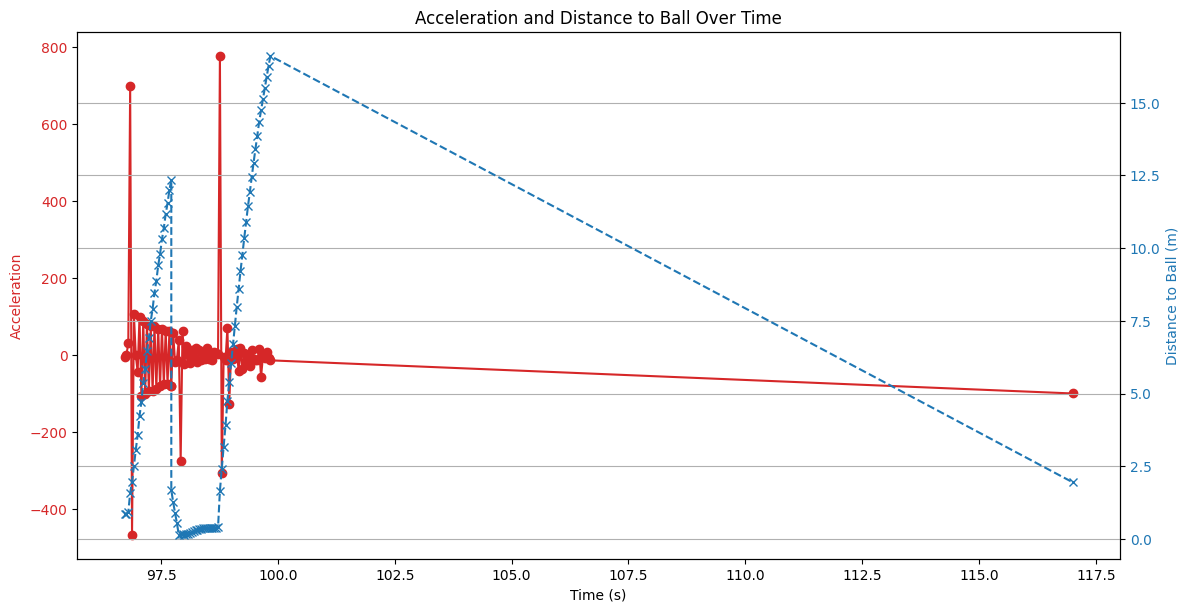

In [289]:

# Calculate distance to the ball
extracted_gps_data["distance_to_ball"] = np.hypot(
    extracted_gps_data["x"] - extracted_gps_data["ball_x"],
    extracted_gps_data["y"] - extracted_gps_data["ball_y"]
)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Acceleration plot
color = 'tab:red'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Acceleration', color=color)
ax1.plot(extracted_gps_data['time'][219:300], extracted_gps_data['acceleration'][219:300], color=color, marker='o', label='Acceleration')
ax1.tick_params(axis='y', labelcolor=color)

# Distance to ball plot on a second axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Distance to Ball (m)', color=color)
ax2.plot(extracted_gps_data['time'][219:300], extracted_gps_data['distance_to_ball'][219:300], color=color, marker='x', linestyle='--', label='Distance to Ball')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Acceleration and Distance to Ball Over Time")
plt.grid(True)
plt.show()



In [205]:
extracted_gps_data[extracted_gps_data["time"] == 92.56]

,time,player_id,player_num,x,y,spd,ball_x,ball_y,Team,acceleration,smoothed_acceleration,pass_event_id,distance_to_ball
115,92.56,587ba55f-2607-4e5d-8b6f-8b94c119b81d,16,96.93,34.02,0.2,95.89,34.15,home,-12.5,-2.5,1,1.048094


In [206]:
low_distance = extracted_gps_data[extracted_gps_data["distance_to_ball"] < 2]


In [223]:
import pandas as pd

# Assuming df is your DataFrame
df = low_distance.copy()

# Identify chunks by consecutive player_num
df['player_chunk'] = (df['player_num'] != df['player_num'].shift()).cumsum()

# Get index of max acceleration per chunk
max_acceleration_indices = df.groupby('player_chunk')['acceleration'].idxmax() - 10

# Initialize a list of zeros with length 2500
binary_list = [0] * len(extracted_gps_data)

In [ ]:

# Set positions from max_acceleration_indices to 1, ensuring indices within bounds
for idx in max_acceleration_indices:
    if 0 <= idx < len(extracted_gps_data):
        binary_list[idx] = 1

In [225]:

# Verify the result (optional)
extracted_gps_data["decision_making_point"] = binary_list


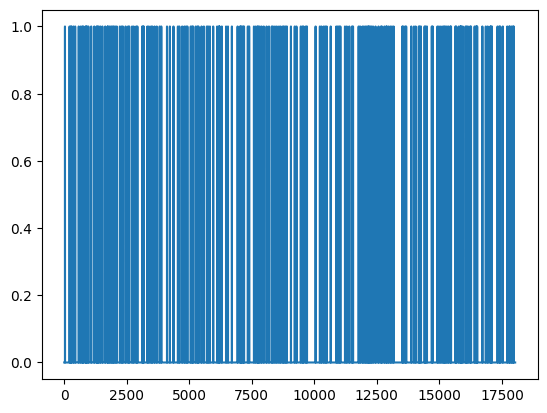

In [385]:
plt.plot(extracted_gps_data["decision_making_point"] )

In [391]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point

# Robust overlap area calculation function
def calculate_overlap_area(target_x, target_y, x_ball, y_ball, away_players, angle_degrees=40, circle_radius=2):
    dx, dy = target_x - x_ball, target_y - y_ball
    height = np.hypot(dx, dy)
    if height == 0:
        return 0.0

    trajectory_angle = np.arctan2(dy, dx)
    half_angle_radians = np.radians(angle_degrees / 2)
    base_width = 2 * height * np.tan(half_angle_radians)

    left_x = target_x + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
    left_y = target_y + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
    right_x = target_x + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
    right_y = target_y + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

    points = [(left_x, left_y), (right_x, right_y), (x_ball, y_ball)]

    triangle = Polygon(points)
    if not triangle.is_valid or triangle.area == 0:
        return 0.0

    total_overlap_area = sum(
        triangle.intersection(Point(away_x, away_y).buffer(circle_radius)).area
        for away_x, away_y in zip(away_players["x"], away_players["y"])
    )

    return total_overlap_area

# Updated custom scoring function with directional boost
def custom_score(overlap_area, distance_to_ball, ball_direction_x, alpha=1.0, beta=0.01, gamma=0.1):
    direction_bonus = gamma if ball_direction_x > 0 else -gamma
    penalty = alpha * overlap_area + beta * distance_to_ball
    return np.exp(-penalty + direction_bonus)

# Placeholder for results
results = []

# Iterate over each row in extracted_gps_data with decision-making points
decision_points = extracted_gps_data[extracted_gps_data["decision_making_point"] == 1].reset_index()

for idx, row in decision_points.iterrows():
    current_time = row["time"]
    current_player_num = row["player_num"]
    x_ball, y_ball = row["ball_x"], row["ball_y"]

    players_at_time = gps_data[(gps_data["time"] == current_time) & 
                               (gps_data["player_num"] != current_player_num)]

    home_players = players_at_time[players_at_time["Team"] == "home"]
    away_players = players_at_time[players_at_time["Team"] == "away"]

    for _, home_player in home_players.iterrows():
        
        ball_direction_x = x_ball -home_player["x"] 

        distance_to_ball = np.hypot(home_player["x"] - x_ball, home_player["y"] - y_ball)
        
        if distance_to_ball < 15:
            circle_radius = 2
        elif 15 < distance_to_ball <= 25:
            circle_radius =3
        else:
            circle_radius=6
        
        overlap_area = calculate_overlap_area(
                target_x=home_player["x"],
                target_y=home_player["y"],
                x_ball=x_ball,
                y_ball=y_ball,
                away_players=away_players,
                angle_degrees=40,
                circle_radius=circle_radius
            )
        # Using custom scoring with directional boost
        score = custom_score(overlap_area, distance_to_ball, ball_direction_x)

        results.append({
            "timestamp": current_time,
            "reference_player_num": current_player_num,
            "target_player_num": home_player["player_num"],
            "score": score,
            "pass_event_id":row["pass_event_id"]
        })

results_df = pd.DataFrame(results)

# Convert to wide format
results_df_wide = results_df.pivot_table(
    index=['timestamp', "pass_event_id",'reference_player_num'],
    columns='target_player_num',
    values='score'
).reset_index()

results_df_wide.columns = [
    f'score_to_player_{int(col)}' if isinstance(col, (int, float)) else col
    for col in results_df_wide.columns
]

# Select columns containing 'score_to_player'
score_columns = [col for col in results_df_wide.columns if 'score_to_player' in col]

# Find the max value per row among score columns
results_df_wide['max_score'] = results_df_wide[score_columns].max(axis=1)

# Find the corresponding player column for each max score
results_df_wide['max_score_player'] = results_df_wide[score_columns].idxmax(axis=1)

# Display the results
print(results_df_wide[['timestamp', 'reference_player_num', 'max_score', 'max_score_player']])

# Extract just the numeric player ID
results_df_wide['max_score_player'] = results_df_wide['max_score_player'].str.extract('score_to_player_(\d+)').astype(int)


<>:117: SyntaxWarning: invalid escape sequence '\d'
<>:117: SyntaxWarning: invalid escape sequence '\d'
/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_6638/2509666769.py:117: SyntaxWarning: invalid escape sequence '\d'
  results_df_wide['max_score_player'] = results_df_wide['max_score_player'].str.extract('score_to_player_(\d+)').astype(int)


     timestamp  reference_player_num  max_score    max_score_player
0         2.60                    24   0.914242  score_to_player_12
1        96.44                    16   0.966157  score_to_player_24
2        98.36                    24   0.869703  score_to_player_18
3        99.52                    24   1.051469  score_to_player_18
4       119.64                    23   0.908986  score_to_player_10
..         ...                   ...        ...                 ...
205    2546.60                    10   1.062354  score_to_player_23
206    2547.84                    10   0.881247  score_to_player_23
207    2586.76                    18   1.005243   score_to_player_8
208    2588.88                    13   0.930798   score_to_player_8
209    2590.16                    13   1.050427  score_to_player_10

[210 rows x 4 columns]


In [392]:
results_df_wide

,timestamp,pass_event_id,reference_player_num,score_to_player_2,score_to_player_8,score_to_player_10,score_to_player_11,score_to_player_12,score_to_player_13,score_to_player_16,score_to_player_18,score_to_player_23,score_to_player_24,score_to_player_28,max_score,max_score_player
0,2.60,0,24,8.708364e-04,1.866990e-02,1.164521e-75,3.444239e-90,9.142421e-01,1.715565e-05,7.220961e-01,1.495561e-03,4.350495e-35,NaN,5.807550e-134,0.914242,12
1,96.44,1,16,7.466029e-01,1.256425e-155,1.693514e-143,4.522644e-119,1.262165e-66,3.469699e-06,NaN,2.292272e-24,6.377359e-41,9.661571e-01,4.750706e-76,0.966157,24
2,98.36,2,24,6.973504e-14,1.383223e-93,1.032048e-197,2.729815e-179,2.867122e-75,4.159418e-11,7.788449e-01,8.697033e-01,8.076284e-81,NaN,2.765000e-120,0.869703,18
3,99.52,2,24,1.497842e-100,2.020999e-27,6.346533e-179,2.185457e-161,4.671994e-14,1.624153e-05,2.115287e-38,1.051469e+00,3.623378e-122,NaN,4.116249e-114,1.051469,18
4,119.64,4,23,2.215070e-01,6.788452e-104,9.089858e-01,8.453840e-26,2.182370e-117,1.632109e-25,5.577062e-04,9.577781e-164,NaN,1.649145e-71,4.241714e-04,0.908986,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2546.60,211,10,3.165574e-23,3.358863e-226,NaN,2.472751e-35,1.121530e-34,1.160669e-08,3.136125e-03,7.510399e-261,1.062354e+00,2.839371e-92,8.090459e-01,1.062354,23
206,2547.84,211,10,6.221468e-100,3.727961e-164,NaN,1.050931e-22,4.175764e-24,6.564556e-107,4.480648e-67,2.919686e-206,8.812473e-01,5.668436e-164,1.561218e-18,0.881247,23
207,2586.76,213,18,7.640766e-35,1.005243e+00,2.163032e-157,1.513875e-17,5.169134e-15,1.843480e-07,3.519958e-30,NaN,2.226803e-99,1.822556e-02,2.947809e-91,1.005243,8
208,2588.88,214,13,2.827269e-06,9.307980e-01,7.571099e-13,5.135569e-06,1.457762e-02,NaN,2.233491e-26,2.015787e-17,3.684934e-08,9.244713e-07,1.632474e-06,0.930798,8


In [322]:
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

def plot_event_overlap(timestamp, from_player_num, gps_data, angle_degrees=40, circle_radius=2):
    # Extract positions at the given timestamp
    df_timestamp = gps_data[gps_data["time"] == timestamp]

    if df_timestamp.empty:
        print(f"No data available for timestamp {timestamp}")
        return

    # Separate home and away teams
    home_players = df_timestamp[df_timestamp["Team"] == "home"]
    away_players = df_timestamp[df_timestamp["Team"] == "away"]

    # Extract the "from" player's position and ball position
    from_player = df_timestamp[df_timestamp["player_num"] == from_player_num].iloc[0]
    x_ball, y_ball = from_player["ball_x"], from_player["ball_y"]

    # Define team colors
    team_colors = {"home": "blue", "away": "red"}

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot all players with their influence circles
    for _, row in df_timestamp.iterrows():
        ax.scatter(row["x"], row["y"], color=team_colors[row["Team"]], alpha=0.7)
        circle = patches.Circle((row["x"], row["y"]), radius=4, color=team_colors[row["Team"]], alpha=0.3)
        ax.add_patch(circle)

    # Highlight the ball
    ax.scatter(x_ball, y_ball, color="yellow", label="Ball", s=120, edgecolor="black", zorder=5)

    # Plot triangle areas for home players (excluding the "from" player itself)
    for _, target_player in home_players.iterrows():
        player_num = target_player["player_num"]
        if player_num == from_player_num:
            continue

        dx, dy = target_player["x"] - x_ball, target_player["y"] - y_ball
        height = np.hypot(dx, dy)
        if height == 0:
            continue

        trajectory_angle = np.arctan2(dy, dx)
        half_angle_radians = np.radians(angle_degrees / 2)
        base_width = 2 * height * np.tan(half_angle_radians)

        left_x = target_player["x"] + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
        left_y = target_player["y"] + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
        right_x = target_player["x"] + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
        right_y = target_player["y"] + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

        triangle = Polygon([(left_x, left_y), (right_x, right_y), (x_ball, y_ball)])

        total_overlap_area = sum(
            triangle.intersection(Point(away_x, away_y).buffer(circle_radius)).area
            for away_x, away_y in zip(away_players["x"], away_players["y"])
        )

        triangle_patch = patches.Polygon(
            [(left_x, left_y), (right_x, right_y), (x_ball, y_ball)],
            edgecolor="black", facecolor="gray", linestyle="dashed", alpha=0.3
        )
        ax.add_patch(triangle_patch)

        ax.text(target_player["x"], target_player["y"], f'{player_num}\n({total_overlap_area:.1f})', 
                fontsize=10, ha='center', va='center', color='black')

    # Set limits and labels
    ax.set_xlim(0, 106)
    ax.set_ylim(0, 68)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Player positions and overlap at timestamp {timestamp} | From Player: {from_player_num}")
    plt.grid(True)

    plt.show()

# Example call:
# plot_event_overlap(timestamp=1.48, from_player_num=24, gps_data=gps_data, angle_degrees=40)


In [323]:
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

def plot_event_overlap(timestamp, from_player_num, gps_data, angle_degrees=40):
    # Extract positions at the given timestamp
    df_timestamp = gps_data[gps_data["time"] == timestamp]

    if df_timestamp.empty:
        print(f"No data available for timestamp {timestamp}")
        return

    # Separate home and away teams
    home_players = df_timestamp[df_timestamp["Team"] == "home"]
    away_players = df_timestamp[df_timestamp["Team"] == "away"]

    # Extract the "from" player's position and ball position
    from_player = df_timestamp[df_timestamp["player_num"] == from_player_num].iloc[0]
    x_ball, y_ball = from_player["ball_x"], from_player["ball_y"]

    # Define team colors
    team_colors = {"home": "blue", "away": "red"}

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot all players with their dynamic influence circles
    for _, row in df_timestamp.iterrows():
        distance_to_ball = np.hypot(row["x"] - x_ball, row["y"] - y_ball)

        if distance_to_ball < 15:
            circle_radius = 2
        elif 15 < distance_to_ball <= 25:
            circle_radius = 3
        else:
            circle_radius = 6

        ax.scatter(row["x"], row["y"], color=team_colors[row["Team"]], alpha=0.7)
        circle = patches.Circle((row["x"], row["y"]), radius=circle_radius, color=team_colors[row["Team"]], alpha=0.3)
        ax.add_patch(circle)

    # Highlight the ball
    ax.scatter(x_ball, y_ball, color="yellow", label="Ball", s=120, edgecolor="black", zorder=5)

    # Plot triangle areas for home players (excluding the "from" player itself)
    for _, target_player in home_players.iterrows():
        player_num = target_player["player_num"]
        if player_num == from_player_num:
            continue

        distance_to_ball = np.hypot(target_player["x"] - x_ball, target_player["y"] - y_ball)

        if distance_to_ball < 15:
            circle_radius = 2
        elif 15 < distance_to_ball <= 25:
            circle_radius = 3
        else:
            circle_radius = 6

        dx, dy = target_player["x"] - x_ball, target_player["y"] - y_ball
        height = np.hypot(dx, dy)
        if height == 0:
            continue

        trajectory_angle = np.arctan2(dy, dx)
        half_angle_radians = np.radians(angle_degrees / 2)
        base_width = 2 * height * np.tan(half_angle_radians)

        left_x = target_player["x"] + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
        left_y = target_player["y"] + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
        right_x = target_player["x"] + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
        right_y = target_player["y"] + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

        triangle = Polygon([(left_x, left_y), (right_x, right_y), (x_ball, y_ball)])

        total_overlap_area = sum(
            triangle.intersection(Point(away_x, away_y).buffer(circle_radius)).area
            for away_x, away_y in zip(away_players["x"], away_players["y"])
        )

        triangle_patch = patches.Polygon(
            [(left_x, left_y), (right_x, right_y), (x_ball, y_ball)],
            edgecolor="black", facecolor="gray", linestyle="dashed", alpha=0.3
        )
        ax.add_patch(triangle_patch)

        ax.text(target_player["x"], target_player["y"], f'{player_num}\n({total_overlap_area:.1f})', 
                fontsize=10, ha='center', va='center', color='black')

    # Set limits and labels
    ax.set_xlim(0, 106)
    ax.set_ylim(0, 68)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Player positions and overlap at timestamp {timestamp} | From Player: {from_player_num}")
    plt.grid(True)

    plt.show()

In [399]:
only_24 = results_df_wide[results_df_wide["reference_player_num"] == 24]
only_2 = results_df_wide[results_df_wide["reference_player_num"] == 2]

In [403]:
only_24

,timestamp,pass_event_id,reference_player_num,score_to_player_2,score_to_player_8,score_to_player_10,score_to_player_11,score_to_player_12,score_to_player_13,score_to_player_16,score_to_player_18,score_to_player_23,score_to_player_24,score_to_player_28,max_score,max_score_player
0,2.60,0,24,8.708364e-04,1.866990e-02,1.164521e-75,3.444239e-90,9.142421e-01,1.715565e-05,7.220961e-01,1.495561e-03,4.350495e-35,NaN,5.807550e-134,0.914242,12
2,98.36,2,24,6.973504e-14,1.383223e-93,1.032048e-197,2.729815e-179,2.867122e-75,4.159418e-11,7.788449e-01,8.697033e-01,8.076284e-81,NaN,2.765000e-120,0.869703,18
3,99.52,2,24,1.497842e-100,2.020999e-27,6.346533e-179,2.185457e-161,4.671994e-14,1.624153e-05,2.115287e-38,1.051469e+00,3.623378e-122,NaN,4.116249e-114,1.051469,18
19,242.84,19,24,6.256441e-107,1.256543e-05,5.668740e-179,5.314787e-110,3.958696e-02,1.306864e-15,1.265445e-17,2.033473e-01,3.435366e-170,NaN,1.103177e-113,0.203347,18
34,378.68,34,24,1.816643e-09,6.657203e-51,1.045530e-171,4.056132e-140,5.012513e-24,6.721360e-02,7.366685e-01,3.846110e-01,4.703459e-116,NaN,2.516689e-103,0.736669,16
35,380.56,34,24,1.280331e-148,9.926106e-01,1.968788e-202,2.268083e-111,4.887457e-03,2.031743e-14,1.147649e-47,8.737284e-01,1.391266e-195,NaN,6.153650e-143,0.992611,8
36,398.52,36,24,7.107602e-01,7.099746e-105,9.035991e-117,2.373988e-194,1.500088e-192,9.832531e-01,7.227766e-01,6.297156e-04,7.378555e-56,NaN,9.279195e-67,0.983253,13
46,544.40,46,24,2.604236e-04,4.940348e-06,1.488887e-213,7.278175e-178,8.189824e-116,1.115204e-15,9.542441e-05,3.894589e-07,2.232456e-13,NaN,3.305021e-30,0.000260,2
57,699.08,57,24,9.948976e-01,3.536837e-79,2.122755e-170,5.329480e-191,1.950353e-03,1.036735e-06,7.971365e-01,9.569997e-01,7.912035e-09,NaN,2.073242e-154,0.994898,2
59,703.80,59,24,7.657023e-01,6.020776e-106,3.499152e-170,1.031790e-156,2.008211e-18,5.252078e-09,7.306195e-01,1.005505e+00,7.645723e-46,NaN,1.507262e-123,1.005505,18


In [408]:
only_24_reset_index= only_24.reset_index(drop=True)
only_24_reset_index.index= only_24_reset_index.index + 1

In [410]:
from pathlib import Path
# Folder containing the plot images
folder = Path("/Users/annadaugaard/Desktop/VFF/explore/plots_annotations_payer_24_focus")

# Extract plot IDs from filenames
plot_ids = []
pattern = r"plot_(\d+)_from_\d+_to_\d+\.png"

for file in folder.glob("plot_*.png"):
    match = re.match(pattern, file.name)
    if match:
        plot_ids.append(int(match.group(1)))

# Now subset the dataframe by index
subset_df = only_24_reset_index[only_24_reset_index.index.isin(plot_ids)]

In [417]:
subset_df.to_csv("passes_from_player24_plots_and_pass_events.csv")

In [411]:
len(subset_df)

36

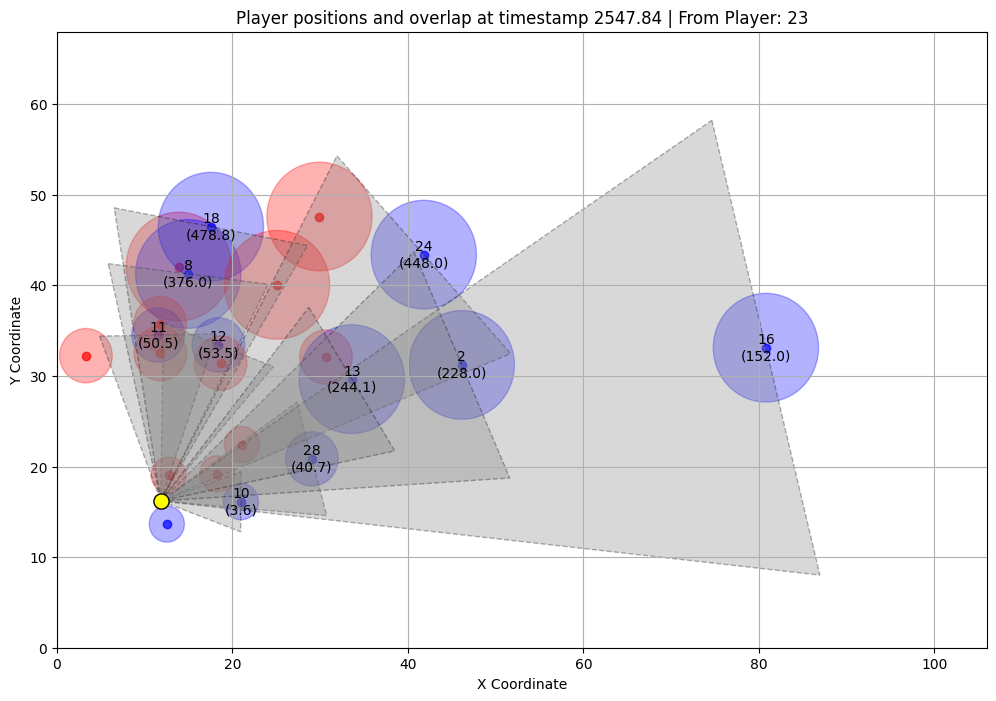

In [326]:
plot_event_overlap(2547.84, 23, gps_data, angle_degrees=40)

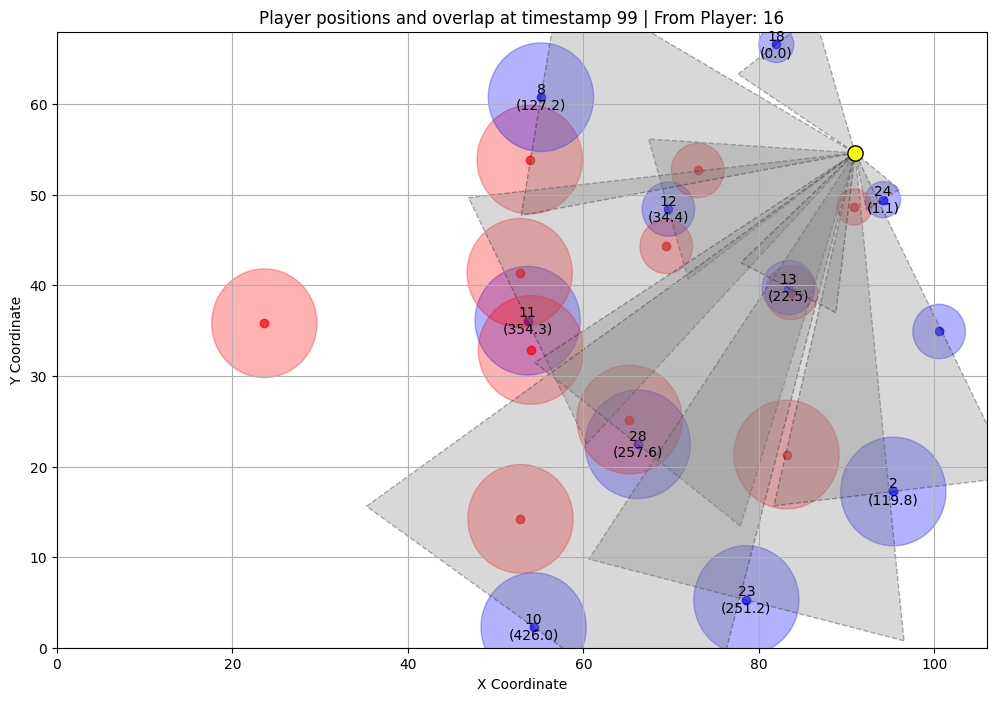

In [335]:
plot_event_overlap(99, 16, gps_data, angle_degrees=40)

In [336]:
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

def plot_event_overlap(timestamp, from_player_num, gps_data, optimal_player_num, angle_degrees=40):
    # Extract positions at the given timestamp
    df_timestamp = gps_data[gps_data["time"] == timestamp]

    if df_timestamp.empty:
        print(f"No data available for timestamp {timestamp}")
        return

    # Separate home and away teams
    home_players = df_timestamp[df_timestamp["Team"] == "home"]
    away_players = df_timestamp[df_timestamp["Team"] == "away"]

    # Extract the "from" player's position and ball position
    from_player = df_timestamp[df_timestamp["player_num"] == from_player_num].iloc[0]
    x_ball, y_ball = from_player["ball_x"], from_player["ball_y"]

    # Define team colors
    team_colors = {"home": "blue", "away": "red"}

    # Plot setup
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot all players with their dynamic influence circles
    for _, row in df_timestamp.iterrows():
        distance_to_ball = np.hypot(row["x"] - x_ball, row["y"] - y_ball)

        if distance_to_ball < 15:
            circle_radius = 2
        elif 15 < distance_to_ball <= 25:
            circle_radius = 3
        else:
            circle_radius = 6

        ax.scatter(row["x"], row["y"], color=team_colors[row["Team"]], alpha=0.7)
        circle = patches.Circle((row["x"], row["y"]), radius=circle_radius, color=team_colors[row["Team"]], alpha=0.3)
        ax.add_patch(circle)

    # Highlight the ball
    ax.scatter(x_ball, y_ball, color="yellow", label="Ball", s=120, edgecolor="black", zorder=5)

    # Plot only the optimal player's triangle area
    optimal_player = home_players[home_players["player_num"] == optimal_player_num].iloc[0]

    dx, dy = optimal_player["x"] - x_ball, optimal_player["y"] - y_ball
    height = np.hypot(dx, dy)
    if height != 0:
        trajectory_angle = np.arctan2(dy, dx)
        half_angle_radians = np.radians(angle_degrees / 2)
        base_width = 2 * height * np.tan(half_angle_radians)

        left_x = optimal_player["x"] + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
        left_y = optimal_player["y"] + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
        right_x = optimal_player["x"] + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
        right_y = optimal_player["y"] + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

        triangle_patch = patches.Polygon(
            [(left_x, left_y), (right_x, right_y), (x_ball, y_ball)],
            edgecolor="green", facecolor="green", linestyle="dashed", alpha=0.3
        )
        ax.add_patch(triangle_patch)

        ax.text(optimal_player["x"], optimal_player["y"], f'{int(optimal_player_num)}', 
                fontsize=12, ha='center', va='center', color='black', weight='bold')

    # Set limits and labels
    ax.set_xlim(0, 106)
    ax.set_ylim(0, 68)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Optimal pass option at timestamp {timestamp} | From Player: {int(from_player_num)} to Player: {int(optimal_player_num)}")
    plt.grid(True)

In [337]:
import os

# Create the output directory if it doesn't exist
output_folder = "plots2"
os.makedirs(output_folder, exist_ok=True)

# Loop and save plots
for idx, row in only_24.iterrows():
    timestamp = row["timestamp"]
    from_player_num = row["reference_player_num"]
    optimal_player_num = row["max_score_player"]

    # Plot the event
    plot_event_overlap(timestamp, from_player_num, gps_data, optimal_player_num,angle_degrees=40)

    # Save the plot to file
    plt.savefig(os.path.join(output_folder, f"plot_{idx}_ts_{timestamp}_from_{int(from_player_num)}_to_{int(optimal_player_num)}.png"))
    plt.close()  # Close the figure to avoid memory issues


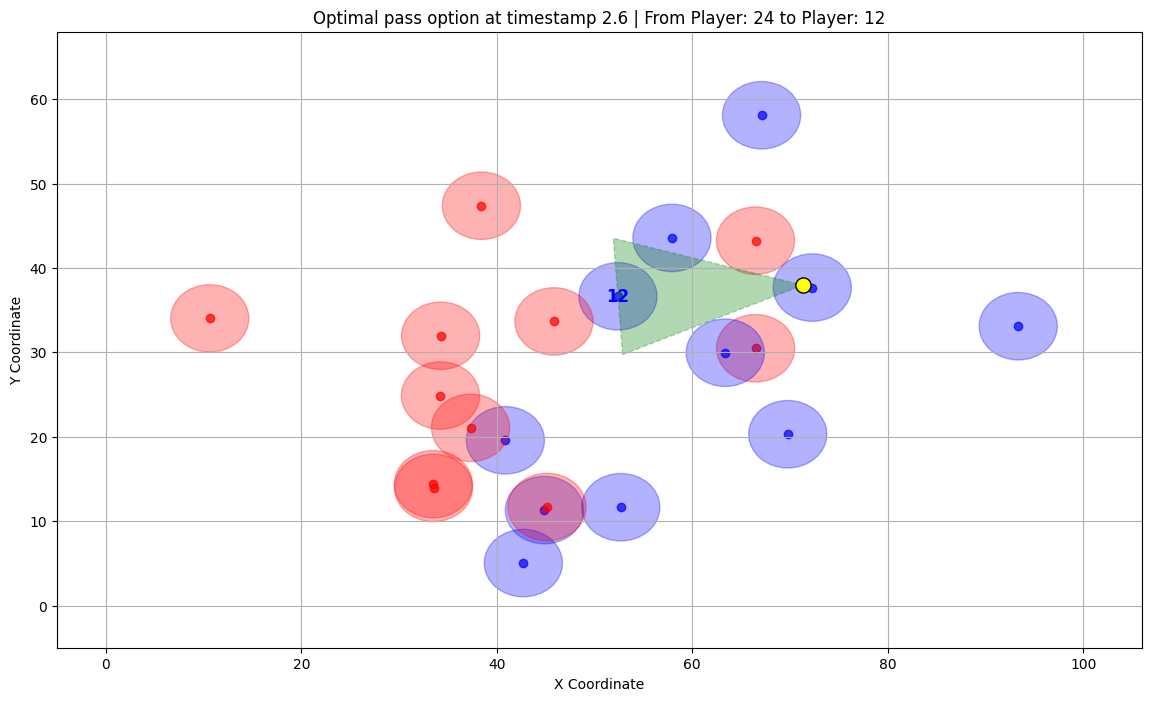

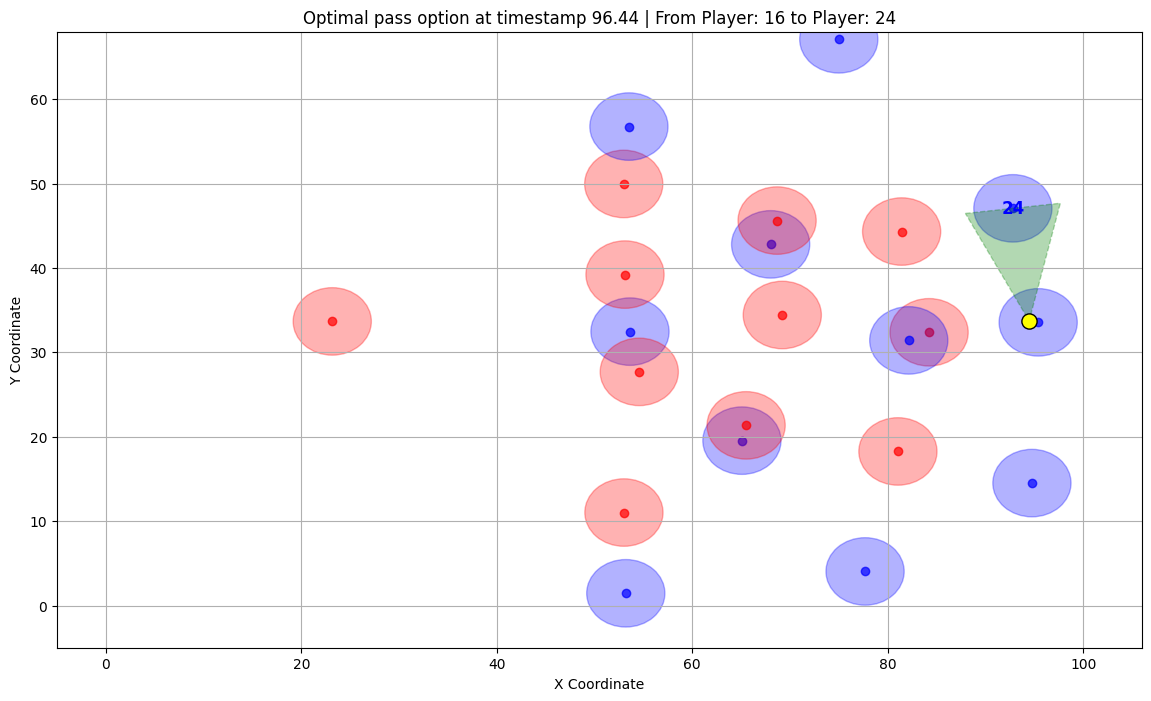

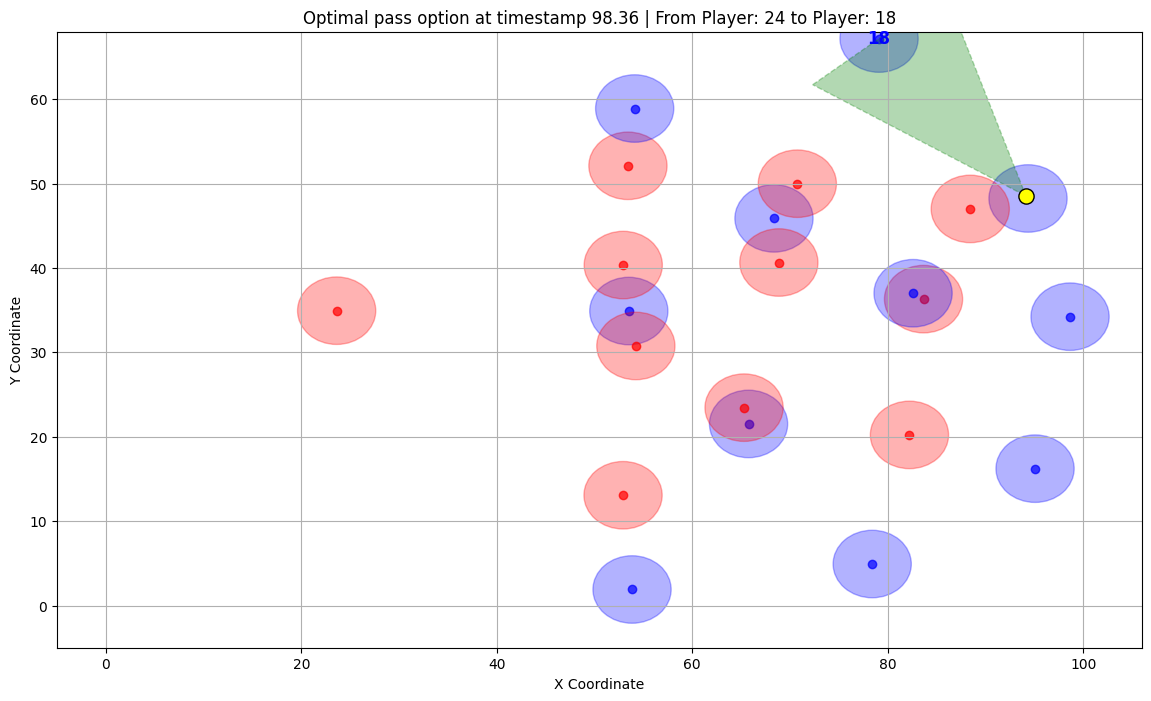

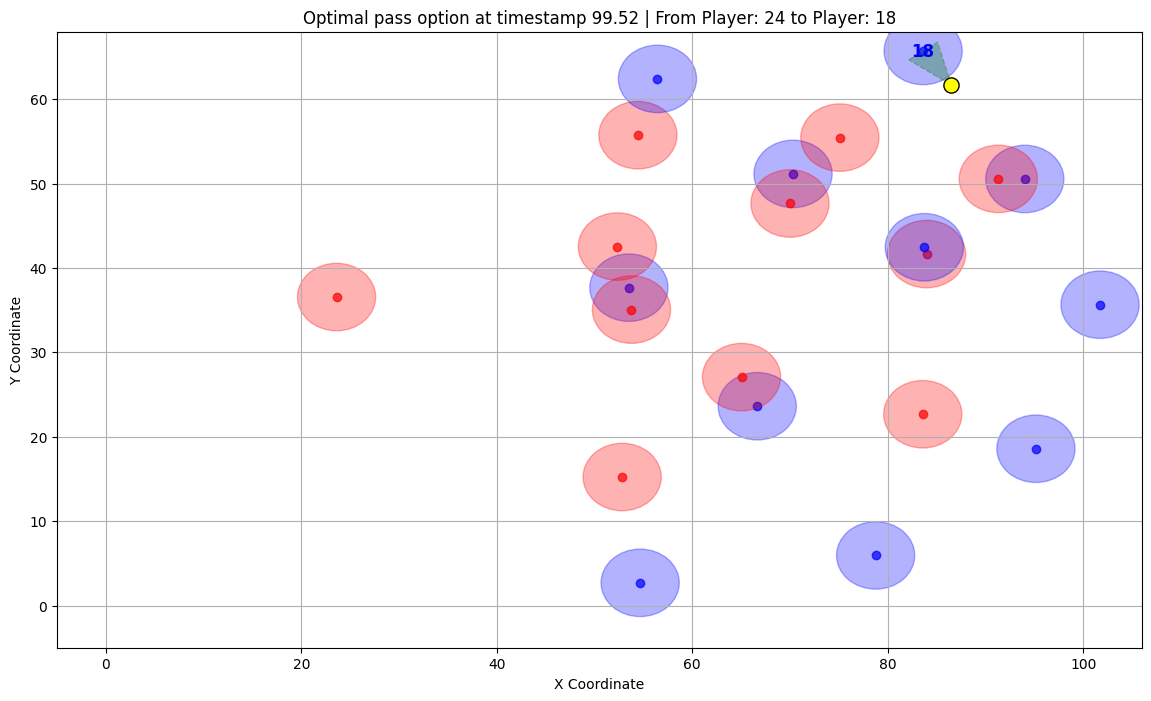

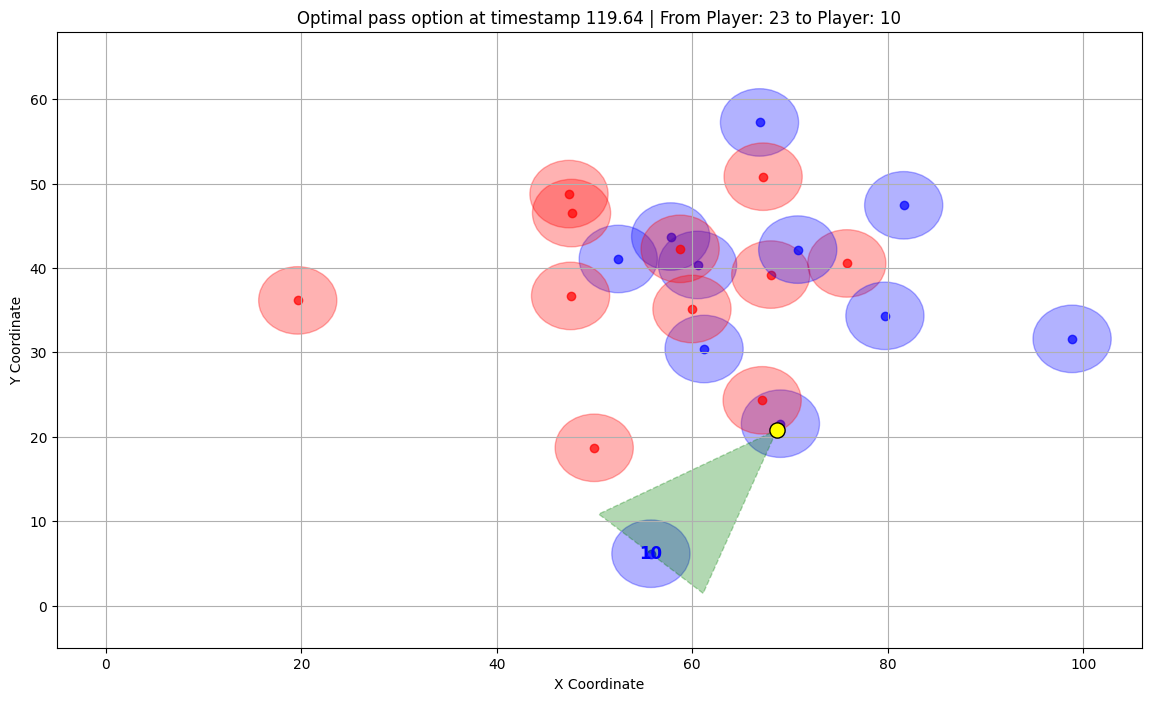

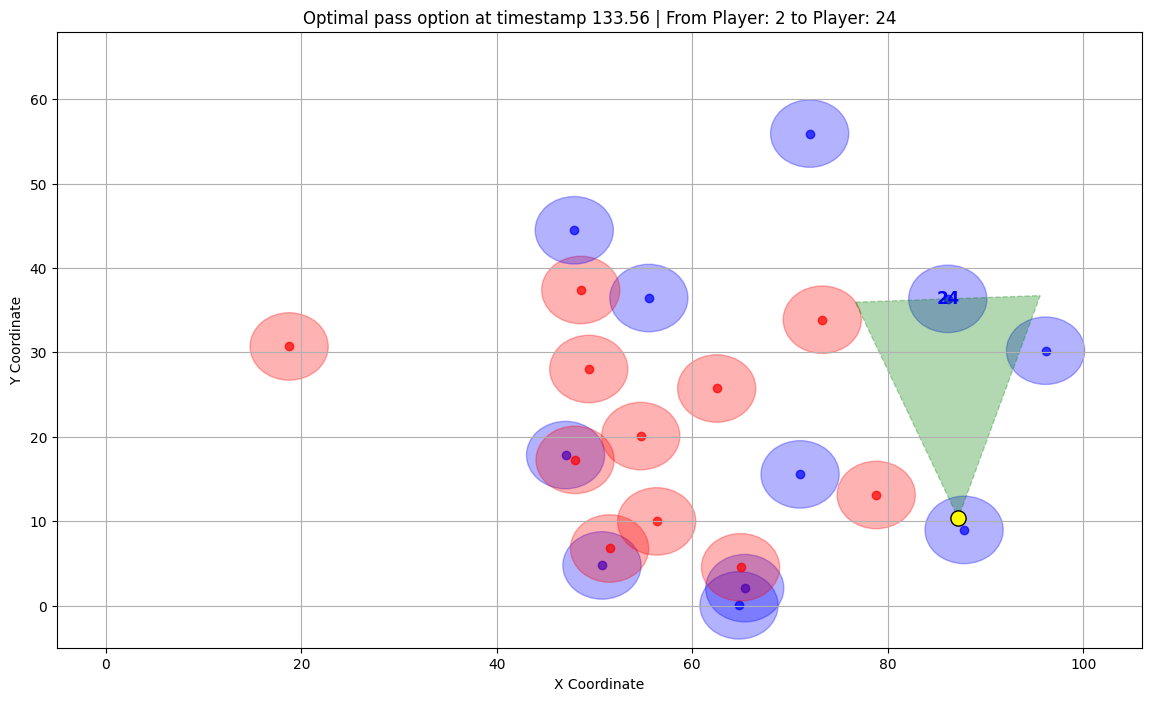

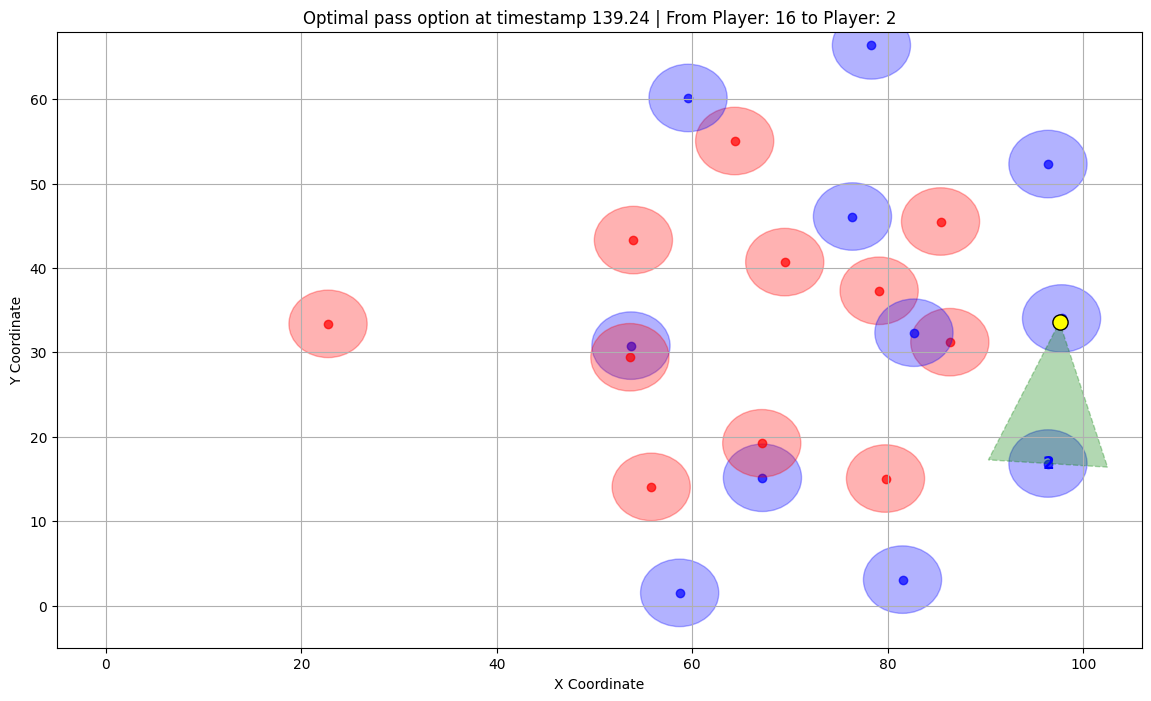

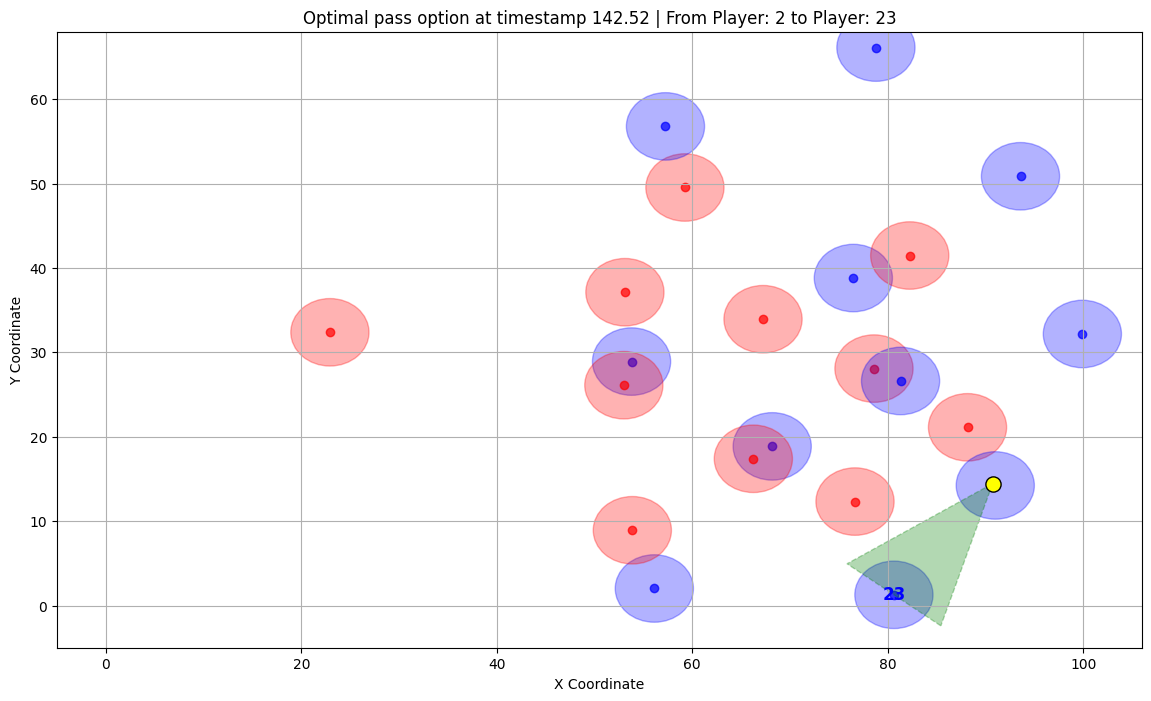

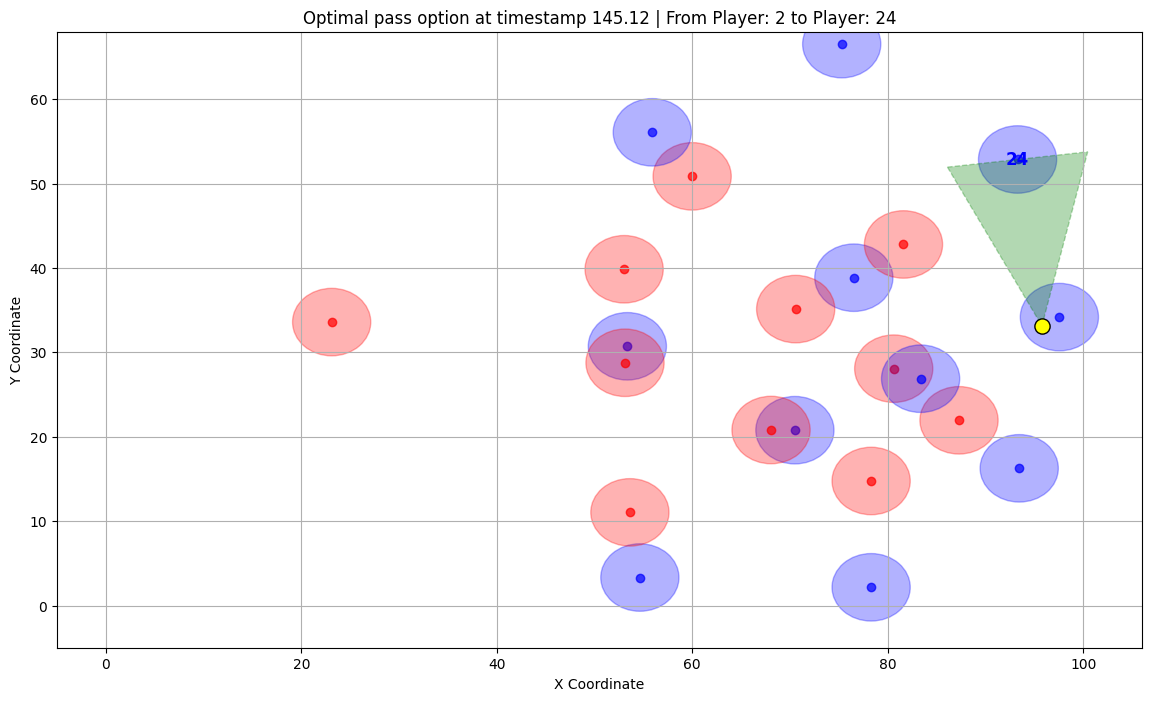

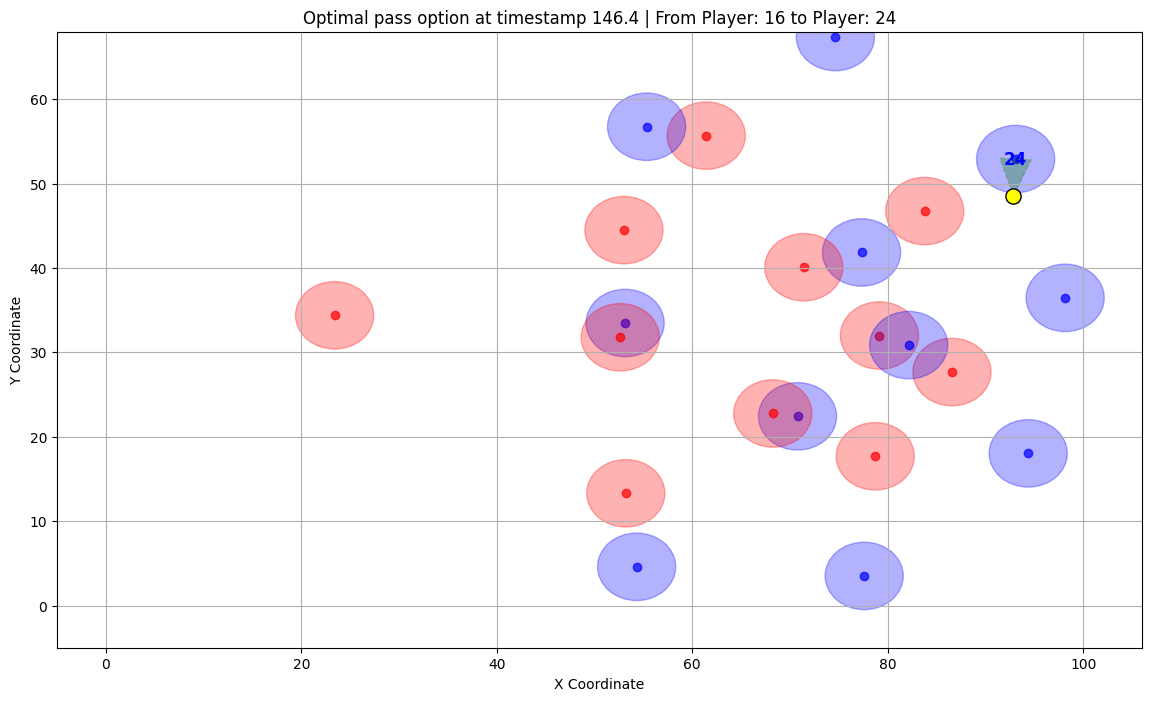

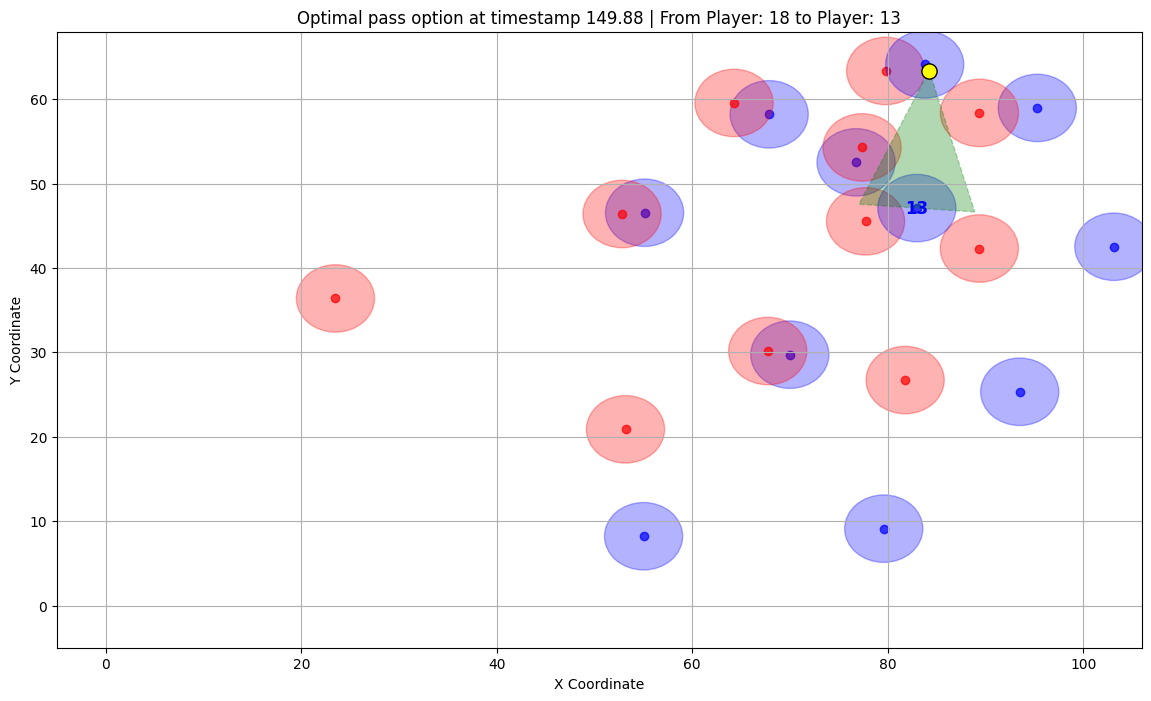

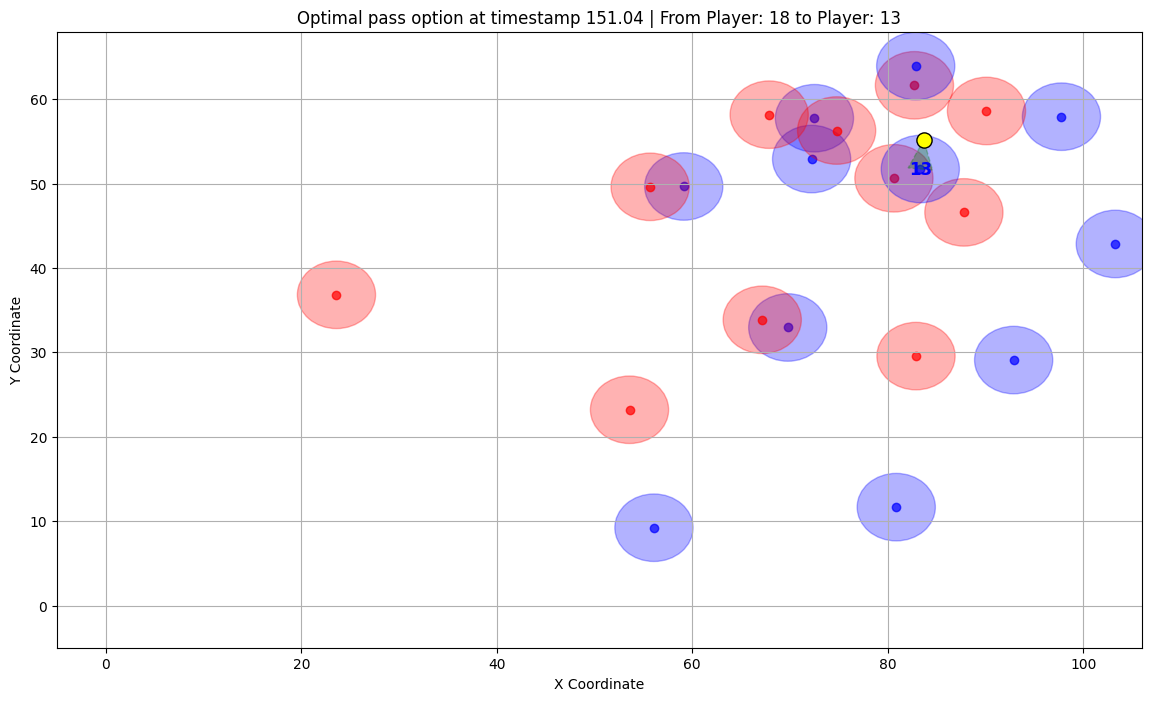

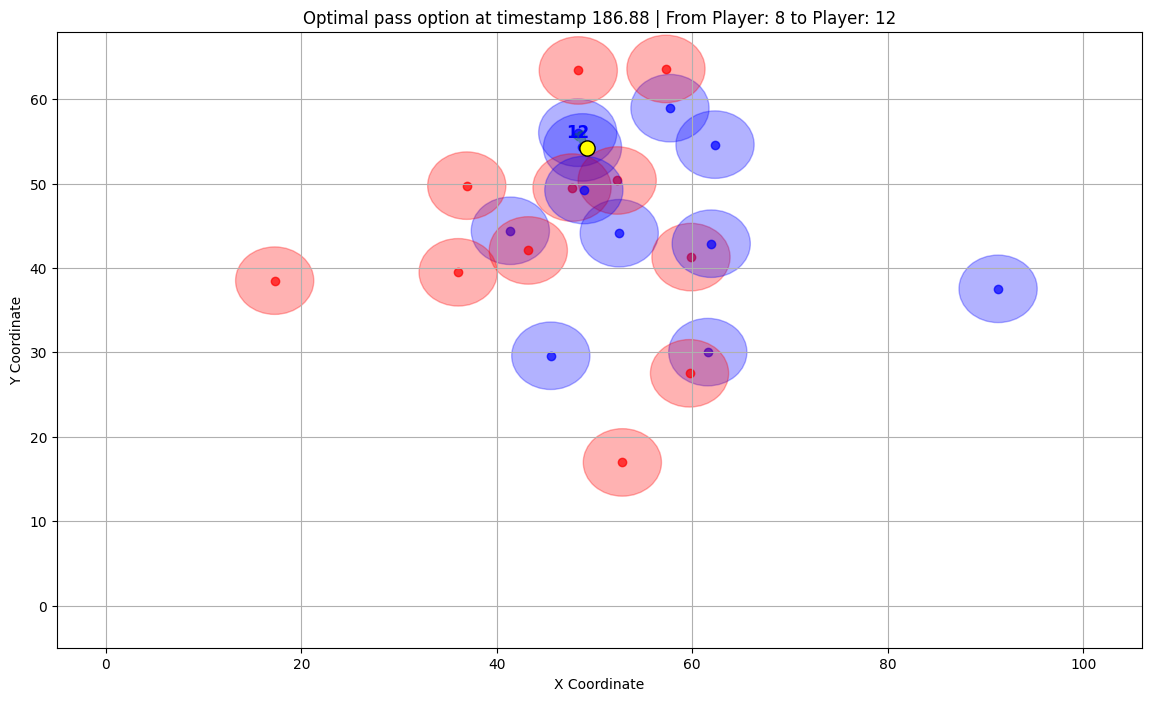

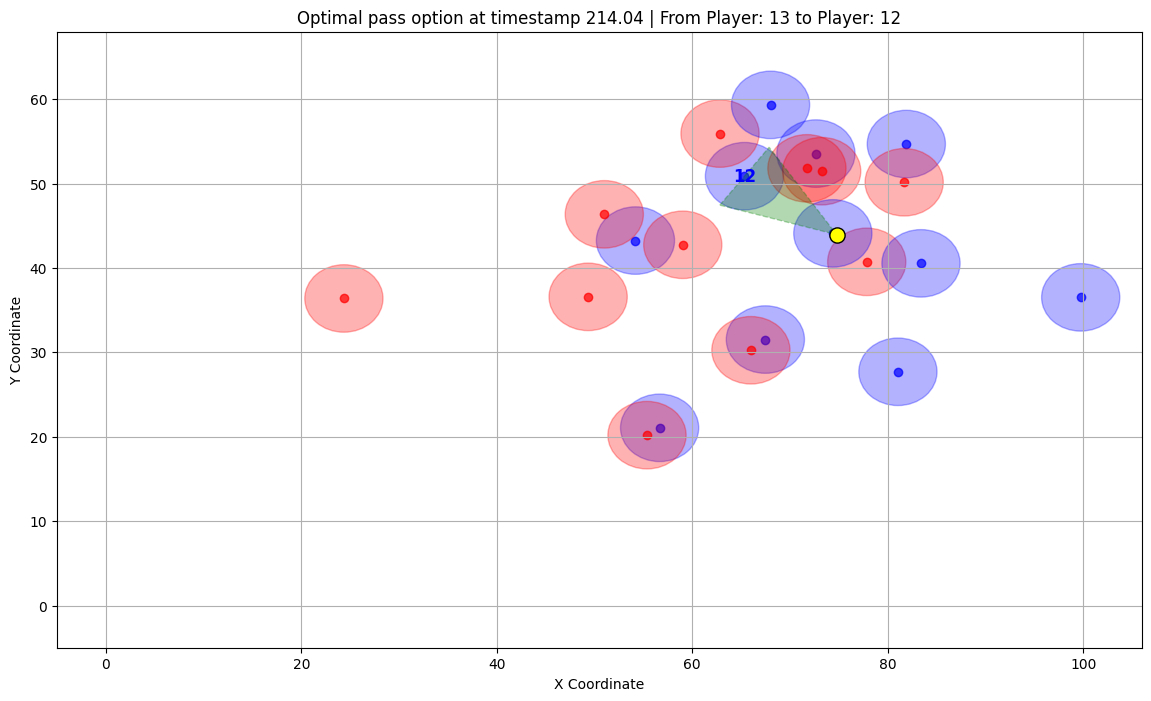

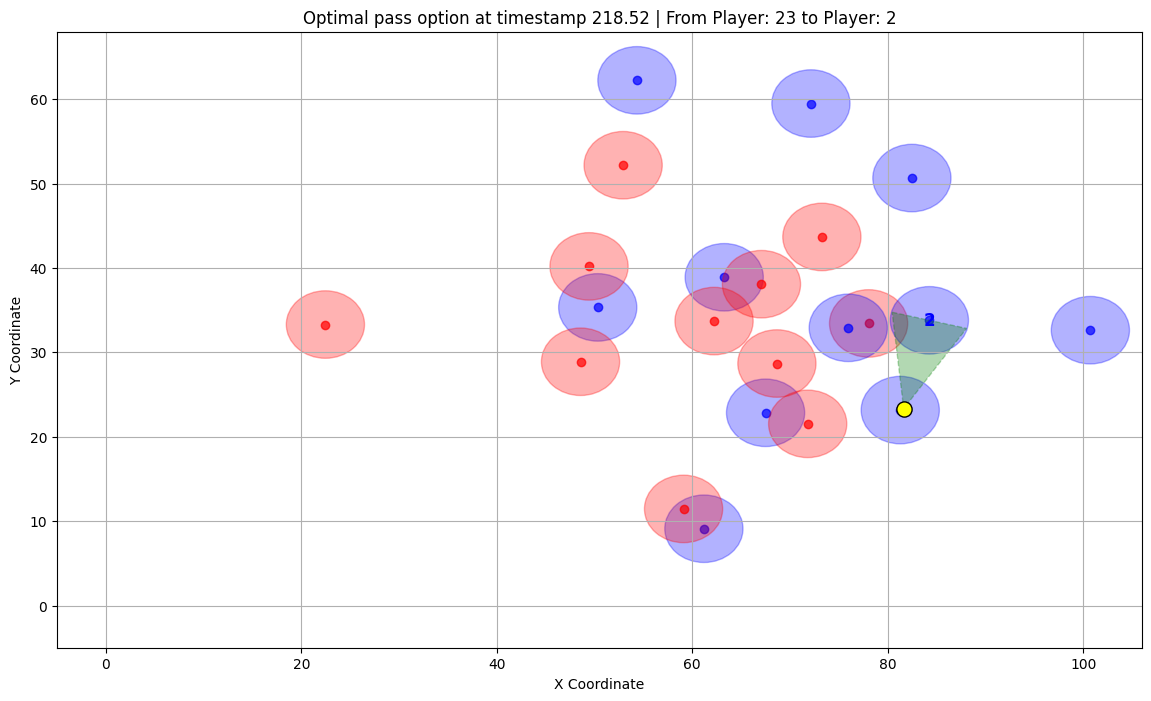

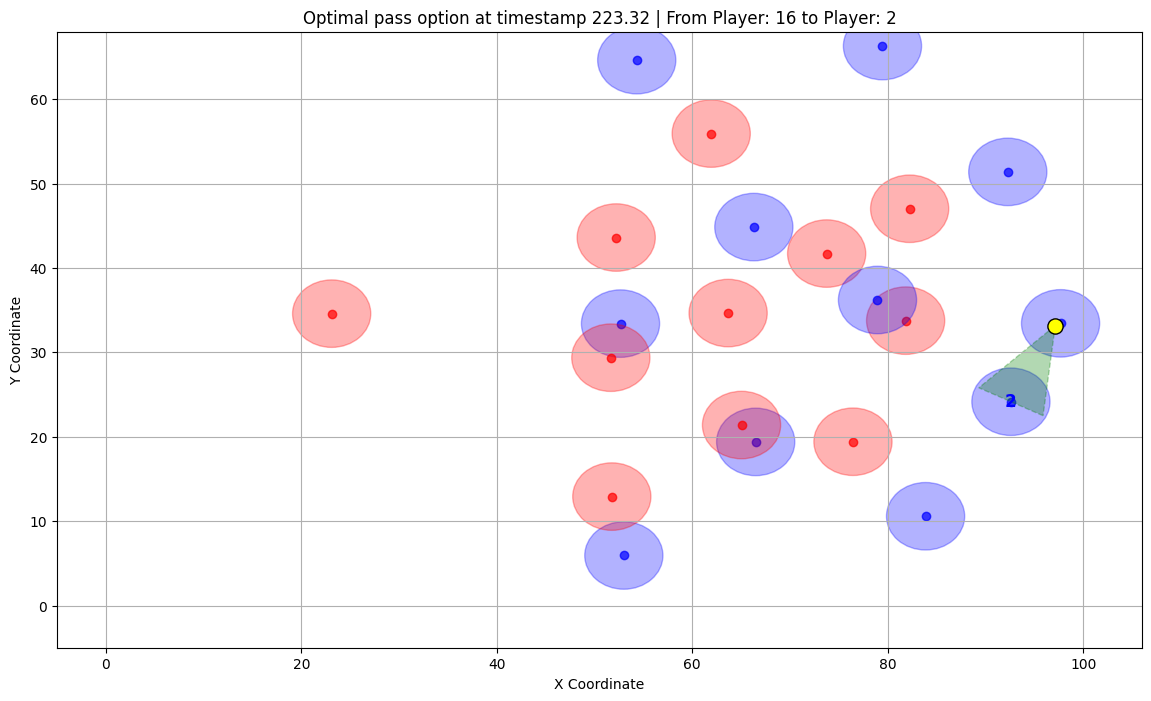

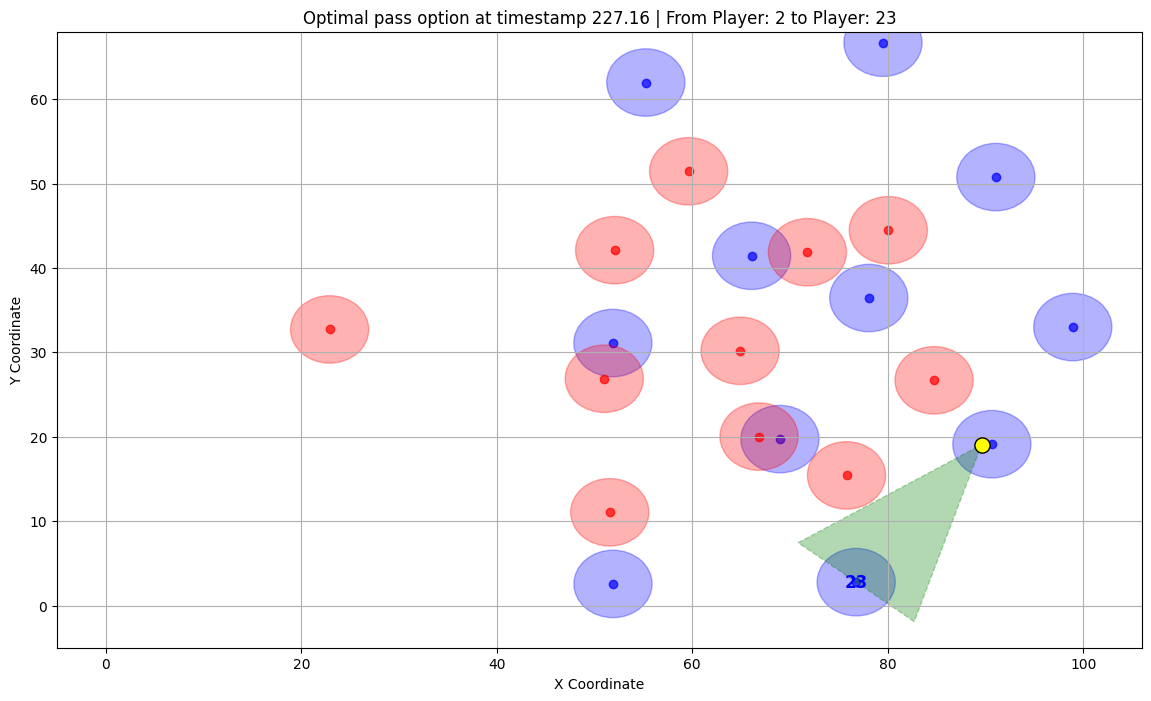

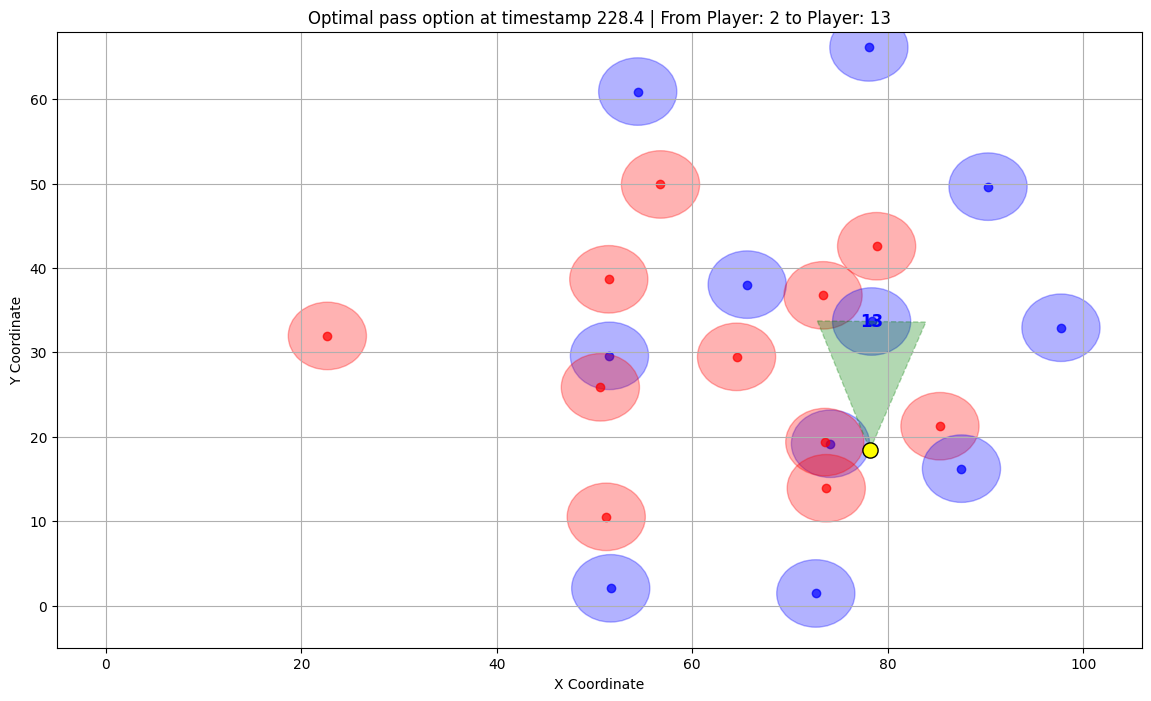

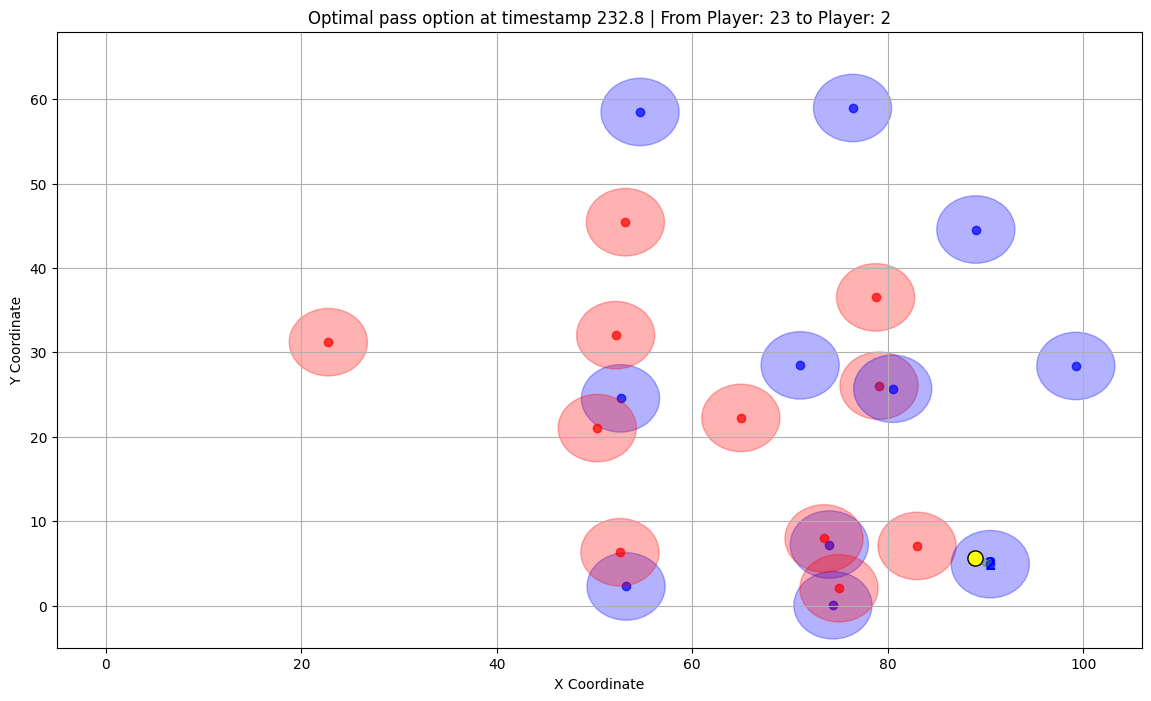

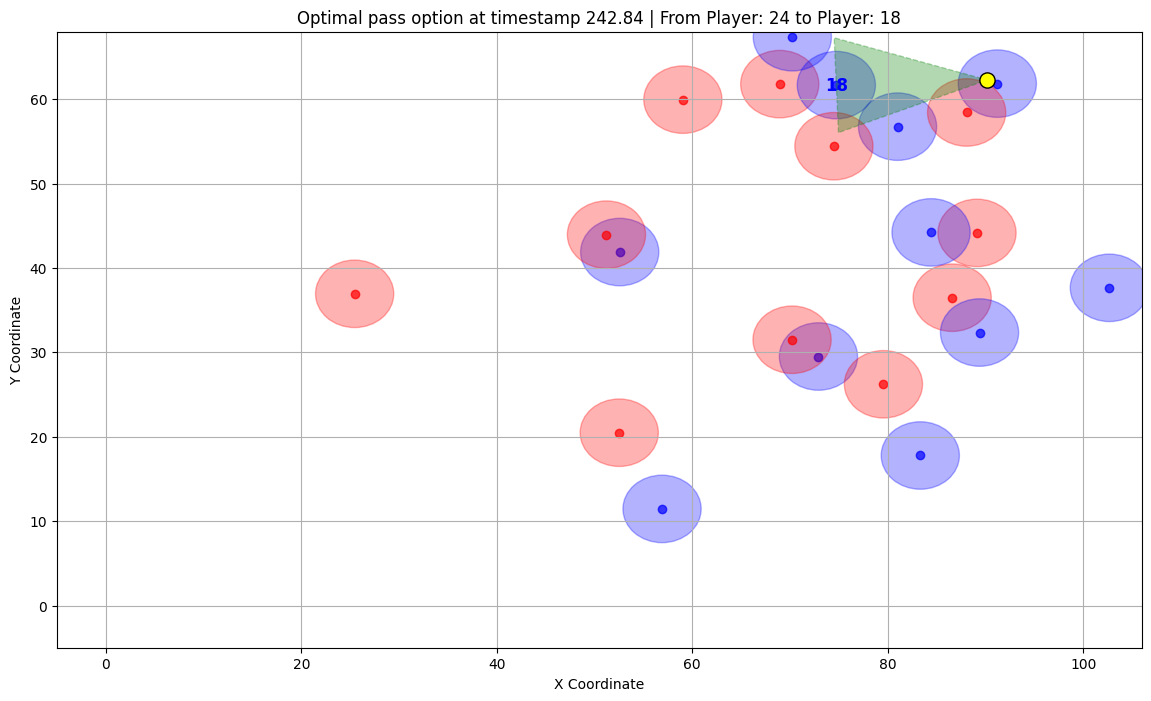

In [275]:
for idx, row in results_df_wide[0:20].iterrows():
    
    plot_event_overlap(results_df_wide["timestamp"][idx], results_df_wide["reference_player_num"][idx], gps_data, results_df_wide['max_score_player'][idx], angle_degrees=40, circle_radius=2)

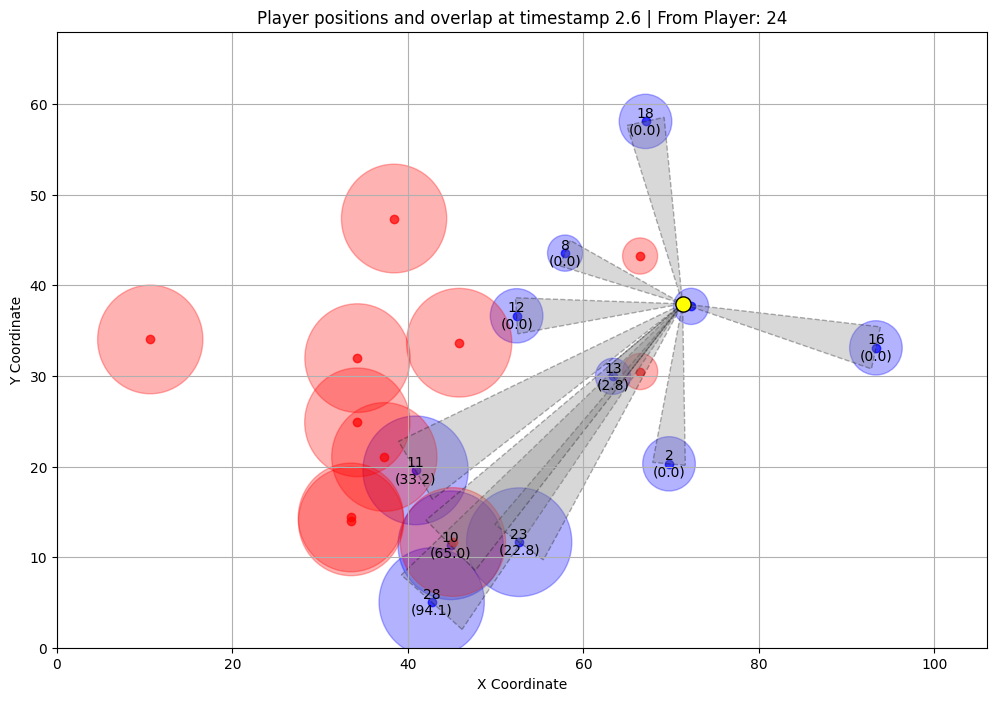

In [329]:

plot_event_overlap(results_df_wide["timestamp"][0], results_df_wide["reference_player_num"][0], gps_data, results_df_wide['max_score_player'][0])

In [308]:
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

def plot_event_overlap(timestamp, from_player_num, gps_data, optimal_player_num, pass_data, angle_degrees=40, circle_radius=2):
    # Extract positions at the given timestamp
    df_timestamp = gps_data[gps_data["time"] == timestamp]

    if df_timestamp.empty:
        print(f"No data available for timestamp {timestamp}")
        return

    # Separate home and away teams
    home_players = df_timestamp[df_timestamp["Team"] == "home"]
    away_players = df_timestamp[df_timestamp["Team"] == "away"]

    # Extract the "from" player's position and ball position
    from_player = df_timestamp[df_timestamp["player_num"] == from_player_num].iloc[0]
    x_ball, y_ball = from_player["ball_x"], from_player["ball_y"]

    # Find actual pass recipient from pass_data
    actual_pass = pass_data[(pass_data["From"] == from_player_num) &
                            (pass_data["Start Time [s]"] <= timestamp) &
                            (pass_data["End Time [s]"] >= timestamp)]

    actual_pass_player_num = actual_pass["To"].iloc[0] if not actual_pass.empty else None

    # Define team colors
    team_colors = {"home": "blue", "away": "red"}

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot all players with their influence circles
    for _, row in df_timestamp.iterrows():
        ax.scatter(row["x"], row["y"], color=team_colors[row["Team"]], alpha=0.7)
        circle = patches.Circle((row["x"], row["y"]), radius=4, color=team_colors[row["Team"]], alpha=0.3)
        ax.add_patch(circle)

    # Highlight the ball
    ax.scatter(x_ball, y_ball, color="yellow", label="Ball", s=120, edgecolor="black", zorder=5)

    # Highlight optimal player's triangle area
    optimal_player = home_players[home_players["player_num"] == optimal_player_num].iloc[0]

    dx, dy = optimal_player["x"] - x_ball, optimal_player["y"] - y_ball
    height = np.hypot(dx, dy)
    if height != 0:
        trajectory_angle = np.arctan2(dy, dx)
        half_angle_radians = np.radians(angle_degrees / 2)
        base_width = 2 * height * np.tan(half_angle_radians)

        left_x = optimal_player["x"] + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
        left_y = optimal_player["y"] + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
        right_x = optimal_player["x"] + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
        right_y = optimal_player["y"] + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

        triangle_patch = patches.Polygon(
            [(left_x, left_y), (right_x, right_y), (x_ball, y_ball)],
            edgecolor="green", facecolor="green", linestyle="dashed", alpha=0.3
        )
        ax.add_patch(triangle_patch)

        ax.text(optimal_player["x"], optimal_player["y"], f'{optimal_player_num}', 
                fontsize=12, ha='center', va='center', color='green', weight='bold')

    # Highlight actual pass recipient
    if actual_pass_player_num and actual_pass_player_num != optimal_player_num:
        actual_player = home_players[home_players["player_num"] == actual_pass_player_num]
        if not actual_player.empty:
            actual_player = actual_player.iloc[0]
            ax.scatter(actual_player["x"], actual_player["y"], color="purple", s=150, edgecolor="black", zorder=6)
            ax.text(actual_player["x"], actual_player["y"], f'{actual_pass_player_num}\n(actual)',
                    fontsize=12, ha='center', va='center', color='purple', weight='bold')

    # Set limits and labels
    ax.set_xlim(0, 106)
    ax.set_ylim(0, 68)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Optimal pass at {timestamp}s | From Player: {from_player_num} to Player: {optimal_player_num}")
    plt.grid(True)

    #plt.show()

# Example call:
# 

#results_df_wide["timestamp"][0], results_df_wide["reference_player_num"][0], gps_data, results_df_wide['max_score_player'][0], angle_degrees=40, circle_radius=2)

In [ ]:
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

def plot_event_overlap(timestamp, from_player_num, gps_data, optimal_player_num, pass_data, angle_degrees=40):
    # Extract positions at the given timestamp
    df_timestamp = gps_data[gps_data["time"] == timestamp]

    if df_timestamp.empty:
        print(f"No data available for timestamp {timestamp}")
        return

    # Separate home and away teams
    home_players = df_timestamp[df_timestamp["Team"] == "home"]
    away_players = df_timestamp[df_timestamp["Team"] == "away"]

    # Extract the "from" player's position and ball position
    from_player = df_timestamp[df_timestamp["player_num"] == from_player_num].iloc[0]
    x_ball, y_ball = from_player["ball_x"], from_player["ball_y"]

    # Find actual pass recipient from pass_data
    actual_pass = pass_data[(pass_data["From"] == from_player_num) &
                            (pass_data["Start Time [s]"] <= timestamp) &
                            (pass_data["End Time [s]"] >= timestamp)]

    actual_pass_player_num = actual_pass["To"].iloc[0] if not actual_pass.empty else None

    # Define team colors
    team_colors = {"home": "blue", "away": "red"}

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot all players with dynamic influence circles and numbers
    for _, row in df_timestamp.iterrows():
        distance_to_ball = np.hypot(row["x"] - x_ball, row["y"] - y_ball)

        if distance_to_ball < 15:
            circle_radius = 2
        elif 15 < distance_to_ball <= 25:
            circle_radius = 3
        else:
            circle_radius = 6

        ax.scatter(row["x"], row["y"], color=team_colors[row["Team"]], alpha=0.7)
        circle = patches.Circle((row["x"], row["y"]), radius=circle_radius, color=team_colors[row["Team"]], alpha=0.3)
        ax.add_patch(circle)

        ax.text(row["x"], row["y"], f'{row["player_num"]}', fontsize=10, ha='center', va='center',
                color='black', weight='bold', path_effects=[path_effects.withStroke(linewidth=3, foreground="white")])

    # Highlight the ball
    ax.scatter(x_ball, y_ball, color="yellow", label="Ball", s=120, edgecolor="black", zorder=5)

    # Highlight optimal player's triangle area
    optimal_player = home_players[home_players["player_num"] == optimal_player_num].iloc[0]

    dx, dy = optimal_player["x"] - x_ball, optimal_player["y"] - y_ball
    height = np.hypot(dx, dy)
    if height != 0:
        trajectory_angle = np.arctan2(dy, dx)
        half_angle_radians = np.radians(angle_degrees / 2)
        base_width = 2 * height * np.tan(half_angle_radians)

        left_x = optimal_player["x"] + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
        left_y = optimal_player["y"] + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
        right_x = optimal_player["x"] + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
        right_y = optimal_player["y"] + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

        triangle_patch = patches.Polygon(
            [(left_x, left_y), (right_x, right_y), (x_ball, y_ball)],
            edgecolor="green", facecolor="green", linestyle="dashed", alpha=0.3
        )
        ax.add_patch(triangle_patch)

    # Highlight actual pass recipient
    if actual_pass_player_num and actual_pass_player_num != optimal_player_num:
        actual_player = home_players[home_players["player_num"] == actual_pass_player_num]
        if not actual_player.empty:
            actual_player = actual_player.iloc[0]
            ax.scatter(actual_player["x"], actual_player["y"], color="purple", s=150, edgecolor="black", zorder=6)
            ax.text(actual_player["x"], actual_player["y"], f'{actual_pass_player_num}\n(actual)',
                    fontsize=12, ha='center', va='center', color='purple', weight='bold',
                    path_effects=[path_effects.withStroke(linewidth=3, foreground="white")])

    # Set limits and labels
    ax.set_xlim(0, 106)
    ax.set_ylim(0, 68)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Optimal pass at {timestamp}s | From Player: {from_player_num} to Player: {optimal_player_num}")
    plt.grid(True)

# plot_event_overlap(timestamp=1.48, from_player_num=24, optimal_player_num=12, gps_data=gps_data, pass_data=pass_data, angle_degrees=40)

# Example call:
# plot_event_overlap(timestamp=1.48, from_player_num=24, optimal_player_num=12, gps_data=gps_data, pass_data=pass_data, angle_degrees=40)


In [357]:
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import numpy as np
import matplotlib.pyplot as plt

def plot_players_and_ball(timestamp, gps_data):
    # Extract positions at the given timestamp
    df_timestamp = gps_data[gps_data["time"] == timestamp]

    if df_timestamp.empty:
        print(f"No data available for timestamp {timestamp}")
        return

    # Define team colors
    team_colors = {"home": "blue", "away": "red"}

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 7))
    

    # Find ball position (assuming it's stored with a player)
    ball_row = df_timestamp.iloc[0]
    x_ball, y_ball = ball_row["ball_x"], ball_row["ball_y"]

    # Plot all players with influence circles
    for _, row in df_timestamp.iterrows():
        distance_to_ball = np.hypot(row["x"] - x_ball, row["y"] - y_ball)

        if distance_to_ball < 15:
            circle_radius = 2
        elif 15 < distance_to_ball <= 25:
            circle_radius = 3
        else:
            circle_radius = 6

        ax.scatter(row["x"], row["y"], color=team_colors[row["Team"]], alpha=0.7)
        circle = patches.Circle((row["x"], row["y"]), radius=circle_radius,
                                color=team_colors[row["Team"]], alpha=0.3)
        ax.add_patch(circle)

        ax.text(row["x"], row["y"], f'{row["player_num"]}', fontsize=10,
                ha='center', va='center', color='black', weight='bold',
                path_effects=[path_effects.withStroke(linewidth=3, foreground="white")])

    # Plot ball
    ax.scatter(x_ball, y_ball, color="yellow", label="Ball", s=120,
               edgecolor="black", zorder=5)

    # Set limits and labels
    ax.set_xlim(0, 110)
    ax.set_ylim(0, 72)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Players and Ball Positions at {timestamp}s")
    plt.grid(True)
    #plt.show()

In [358]:
# Create the output directory if it doesn't exist

output_folder = "plots_annotations_only_player_44"
os.makedirs(output_folder, exist_ok=True)
count = 0
for idx, row in only_2.iterrows():
    count += 1
    #plot_event_overlap(timestamp=row["timestamp"], from_player_num=row["reference_player_num"], optimal_player_num=row["max_score_player"], gps_data=gps_data, pass_data=pass_data, angle_degrees=40)
        # Save the plot to file
    plot_players_and_ball(timestamp=row["timestamp"], gps_data=gps_data)
    plt.savefig(os.path.join(output_folder, f"plot_{count}_from_{int(row["reference_player_num"])}_to_{int(row["max_score_player"])}.png"))
    plt.close()  # Close the figure to avoid memory issues

In [ ]:
import os
import shutil
import re

source_folder = '/Users/annadaugaard/Desktop/VFF/explore/plots_annotations_only_player_2'
dest_folder = '/Users/annadaugaard/Desktop/VFF/explore/plots_til_annotering_player_2'

# Create destination folder if it doesn't exist
os.makedirs(dest_folder, exist_ok=True)

# Regex pattern to extract the number after "plot_"
pattern = re.compile(r'(plot_\d+)_from.*')

for filename in os.listdir(source_folder):
    match = pattern.match(filename)
    if match:
        new_filename = f"{match.group(1)}.png"  # Adjust extension if needed
        src = os.path.join(source_folder, filename)
        
        dst = os.path.join(dest_folder, new_filename)
        shutil.copy(src, dst)
        print(f"Copied {filename} to {new_filename}")



Copied plot_15_from_2_to_24.png to plot_15.png
Copied plot_11_from_2_to_23.png to plot_11.png
Copied plot_8_from_2_to_24.png to plot_8.png
Copied plot_28_from_2_to_16.png to plot_28.png
Copied plot_20_from_2_to_23.png to plot_20.png
Copied plot_31_from_2_to_23.png to plot_31.png
Copied plot_18_from_2_to_16.png to plot_18.png
Copied plot_10_from_2_to_23.png to plot_10.png
Copied plot_14_from_2_to_23.png to plot_14.png
Copied plot_2_from_2_to_23.png to plot_2.png
Copied plot_21_from_2_to_23.png to plot_21.png
Copied plot_29_from_2_to_16.png to plot_29.png
Copied plot_36_from_2_to_16.png to plot_36.png
Copied plot_1_from_2_to_16.png to plot_1.png
Copied plot_32_from_2_to_23.png to plot_32.png
Copied plot_9_from_2_to_13.png to plot_9.png
Copied plot_13_from_2_to_23.png to plot_13.png
Copied plot_22_from_2_to_23.png to plot_22.png
Copied plot_35_from_2_to_16.png to plot_35.png
Copied plot_6_from_2_to_12.png to plot_6.png
Copied plot_26_from_2_to_24.png to plot_26.png
Copied plot_24_from_2_t

In [380]:
image_files

['plot_1.png',
 'plot_10.png',
 'plot_11.png',
 'plot_12.png',
 'plot_13.png',
 'plot_14.png',
 'plot_15.png',
 'plot_16.png',
 'plot_18.png',
 'plot_19.png',
 'plot_2.png',
 'plot_20.png',
 'plot_21.png',
 'plot_22.png',
 'plot_23.png',
 'plot_24.png',
 'plot_26.png',
 'plot_27.png',
 'plot_28.png',
 'plot_29.png',
 'plot_31.png',
 'plot_32.png',
 'plot_33.png',
 'plot_35.png',
 'plot_36.png',
 'plot_4.png',
 'plot_6.png',
 'plot_8.png',
 'plot_9.png',
 'resized_plot_1.png',
 'resized_plot_10.png',
 'resized_plot_11.png',
 'resized_plot_12.png',
 'resized_plot_13.png',
 'resized_plot_14.png',
 'resized_plot_15.png',
 'resized_plot_16.png',
 'resized_plot_18.png',
 'resized_plot_19.png',
 'resized_plot_2.png',
 'resized_plot_20.png',
 'resized_plot_21.png',
 'resized_plot_22.png',
 'resized_plot_23.png',
 'resized_plot_24.png',
 'resized_plot_26.png',
 'resized_plot_27.png',
 'resized_plot_28.png',
 'resized_plot_29.png',
 'resized_plot_31.png',
 'resized_plot_32.png',
 'resized_plot_3

In [384]:
import os
import re
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from PIL import Image as PILImage

# Folder containing images
image_folder = "/Users/annadaugaard/Desktop/VFF/explore/spiller_24_fokus"
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
image_files = sorted(image_files, key=lambda x: int(x.split('_')[1].split('.')[0]))

# Create workbook and sheet
wb = Workbook()
ws = wb.active
ws.title = "Plots"

# Set column headers
ws.cell(row=1, column=1, value="Picture ID")
ws.cell(row=1, column=2, value="Image")
ws.cell(row=1, column=3, value="Choice")

# Adjust columns width
ws.column_dimensions['A'].width = 15
ws.column_dimensions['B'].width = 50
ws.column_dimensions['C'].width = 20

# Insert images with their IDs
for idx, img_file in enumerate(image_files, start=2):  # start from row 2 due to headers
    # Extract numeric ID from filename (e.g., plot_1.png -> 1)
    match = re.search(r'(\d+)', img_file)
    pic_id = match.group(1) if match else "Unknown"

    # Add Picture ID in column A
    ws.cell(row=idx, column=1, value=int(pic_id))

    # Prepare image path
    img_path = os.path.join(image_folder, img_file)
    img = PILImage.open(img_path)
    
    max_height = 600
    if img.height > max_height:
        ratio = max_height / float(img.height)
        new_width = int(img.width * ratio)
        img = img.resize((new_width, max_height), PILImage.LANCZOS)
        resized_path = os.path.join(image_folder, f"resized_{img_file}")
        img.save(resized_path)
        img_to_excel = Image(resized_path)
    else:
        img_to_excel = Image(img_path)

    # Insert image in column B
    cell_location = f"B{idx}"
    ws.row_dimensions[idx].height = img_to_excel.height * 0.75
    ws.add_image(img_to_excel, cell_location)

    # Column C ("Choice") remains blank for user input
    ws.cell(row=idx, column=3, value="")

# Save workbook
wb.save("plots_with_images_spiller_24.xlsx")
print("Excel file created successfully!")


Excel file created successfully!
